In [1]:
%cd ..
%ls

/home/nas1_userB/sunghyun/dmkim/M2N2
analyze_compute_cost_2.py*    data/                 models/     test.py*
analyze_compute_cost_MLP.py*  EDA/                  notebooks/  tmp/
analyze_compute_cost.py*      Exp/                  outputs/    train.py*
cfgs/                         figures/              plots/      utils/
checkpoints/                  hptune/               README.md*  Vis/
checkpoints_231031/           logs/                 results/    wandb/
cost/                         measure_errorbar.py*  scripts/


In [15]:
import warnings; warnings.filterwarnings("ignore");

import torch
from torch import optim
import torch.nn.functional as F

import numpy as np
from utils.tools import setPlotStyle; setPlotStyle()

import matplotlib.pyplot as plt
from utils.metrics import get_summary_stats

from models.MLP import MLP

import wandb
import hydra
from omegaconf import DictConfig

from utils.logger import make_logger
from utils.argpass import prepare_arguments, configure_exp_id
from utils.tools import SEED_everything, plot_interval

from data.load_data import DataFactory
from Exp.MLP import MLP

from easydict import EasyDict as edict
import yaml
import re
import copy
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gaussian_kde, entropy
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy

In [7]:
# load yaml
cfg = {}
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))

# get cfg
model = "MLP"
with open("cfgs/test_defaults.yaml", "r") as file:
    basic_config = yaml.load(file, Loader=loader)
    cfg.update(basic_config)
with open(f"cfgs/model/{model}.yaml", "r") as file:
    model_config = yaml.load(file, Loader=loader)
    cfg.update({"model": model_config})

In [8]:
args = prepare_arguments(cfg)
print(args)

logger = make_logger(os.path.join(args.log_path, f'{args.exp_id}.log'))
logger.info(f"Configurations: {args}")

# Data
logger.info(f"Preparing {args.dataset} dataset...")
datafactory = DataFactory(args, logger)
train_dataset, train_loader, test_dataset, test_loader = datafactory()
args.num_channels = train_dataset.X.shape[1]
train_X, train_y, test_X, test_y = train_dataset.X, train_dataset.y, test_dataset.X, test_dataset.y

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[2023-12-12 06:36:59,324] Configurations: {'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'SEED': 2023, 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_normalization_None/SEED_2023', 'log_path': './logs/MLP_SWaT_normalization_None/SEED_2023', 'output_path': './outputs/MLP_SWaT_normalization_None/SEED_2023', 'plot_path': './plots/MLP_SWaT_normalization_None/SEED_2023', 'result_path': './results/MLP_SWaT_normalization_None/SEED_2023', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'save_pr_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128, 'use_sigmoid_output': False, 'use_batchnorm': False, 'use_dropout': 

{'exp_id': 'MLP_SWaT_normalization_None', 'infer_options': ['offline_all'], 'SEED': 2023, 'thresholding': 'q95.0', 'dataset': 'SWaT', 'batch_size': 64, 'eval_batch_size': 1, 'window_size': 12, 'stride': 12, 'eval_stride': 12, 'scaler': 'std', 'ttlr': 0.001, 'normalization': 'None', 'gamma': 0.99, 'log_freq': 10, 'checkpoint_path': './checkpoints/MLP_SWaT_normalization_None/SEED_2023', 'log_path': './logs/MLP_SWaT_normalization_None/SEED_2023', 'output_path': './outputs/MLP_SWaT_normalization_None/SEED_2023', 'plot_path': './plots/MLP_SWaT_normalization_None/SEED_2023', 'result_path': './results/MLP_SWaT_normalization_None/SEED_2023', 'plot_anomaly_scores': False, 'plot_recon_status': False, 'save_result': True, 'load_anoscs': True, 'save_outputs': False, 'save_roc_curve': False, 'save_pr_curve': False, 'defaults': [{'model': 'MLP'}], 'model': {'name': 'MLP', 'latent_dim': 128, 'use_sigmoid_output': False, 'use_batchnorm': False, 'use_dropout': False}, 'home_dir': '.', 'device': device(

[2023-12-12 06:37:05,385] train: X - (496800, 51), y - (496800,) test: X - (449919, 51), y - (449919,)
[2023-12-12 06:37:05,424] Complete.
[2023-12-12 06:37:05,425] Preparing dataloader...
[2023-12-12 06:37:05,703] total train dataset- 647, batch_X - torch.Size([64, 12, 51]), batch_y - torch.Size([64, 12])
[2023-12-12 06:37:05,705] total test dataset- 37494, batch_X - torch.Size([1, 12, 51]), batch_y - torch.Size([1, 12])
[2023-12-12 06:37:05,869] Complete.


(496800, 51) (496800,) (449928, 51) (449928,)


## Measure KLD

In [9]:
def kl_mvn(to, fr):
    """
    Calculate `KL(to||fr)`, where `to` and `fr` are pairs of means and covariance matrices
    source code from: https://gist.github.com/ChuaCheowHuan/18977a3e77c0655d945e8af60633e4df
    """
    m_to, S_to = to
    m_fr, S_fr = fr
    
    d = m_fr - m_to
    
    c, lower = scipy.linalg.cho_factor(S_fr)
    def solve(B):
        return scipy.linalg.cho_solve((c, lower), B)
    
    def logdet(S):
        return np.linalg.slogdet(S)[1]

    term1 = np.trace(solve(S_to))
    term2 = logdet(S_fr) - logdet(S_to)
    term3 = d.T @ solve(d)
    return (term1 + term2 + term3 - len(d))/2.

def plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, data, load=True):
    print("="*20)
    print(f"KLD for {data}")
    base_dir = os.path.join("figures", "PCA", data)
    os.makedirs(base_dir, exist_ok=True)
    
    if (load==True) and (os.path.exists(os.path.join(base_dir, "Xpca_train.npy"))):
        Xpca_train = np.load(os.path.join(base_dir, "Xpca_train.npy"))
        Xpca_test = np.load(os.path.join(base_dir, "Xpca_test.npy"))
    else:
        print("finding PCA...")
        T, C = train_X.shape

        # filter anomalies
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        mask = (1-test_y).astype(bool)
        test_X = test_X[mask]
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        data = np.concatenate([train_X, test_X])
        print(data.shape)

        if C < 2:
            Xpca_train = train_X
            Xpca_test = test_X
        else:
            x = range(1, min(C, 31))
            d = -1
            evar = []
            for n in x:
                pca = PCA(n_components=n)
                Xpca = pca.fit_transform(data)
                evar.append(sum(pca.explained_variance_ratio_))
                if d == -1 and sum(pca.explained_variance_ratio_) > 0.99 :
                    d = n
            print("Done!")
            plt.plot(x, evar)
            plt.axvline(d)
            plt.show()

            # kde of PCA'ed outputs.
            pca = PCA(n_components=d) 
            pca_data = pca.fit_transform(data)
            Xpca_train = pca_data[:len(train_X)]
            Xpca_test = pca_data[len(train_X):]
        
        print("saving...")
        with open(os.path.join(base_dir, "Xpca_train.npy"), "wb") as f:
            np.save(f, Xpca_train)
        with open(os.path.join(base_dir, "Xpca_test.npy"), "wb") as f:
            np.save(f, Xpca_test)
            
    print("Estimating Gaussian KLD...")
    _, C = Xpca_train.shape
    train_mu = np.mean(Xpca_train, axis=0)
    test_mu = np.mean(Xpca_test, axis=0)
    train_var = np.array([[np.var(Xpca_train)]]) if C < 2 else np.cov(Xpca_train.T)
    test_var = np.array([[np.var(Xpca_test)]]) if C < 2 else np.cov(Xpca_test.T)
    train_stats = (train_mu, train_var)
    test_stats = (test_mu, test_var)
    e = kl_mvn(test_stats, train_stats)    
    print("KLD: ", e)
    print("train_stats: ", train_stats)
    print("test_stats: ", test_stats)
    print("done")
    print("="*20)
    return e, Xpca_train, Xpca_test

In [10]:
datasets_label = ["SWaT", "WADI", "SMD\n(M-1-4)", "SMD\n(M-2-1)", 
            "MSL\n(P-15)", "SMAP\n(T-3)", "CreditCard","yahoo\n(A1-R20)", "yahoo\n(A1-R55)"]
datasets = ["SWaT", "WADI", "SMD_machine-1-4", "SMD_machine-2-1", 
            "MSL_P-15", "SMAP_T-3", "CreditCard","yahoo_20", "yahoo_55"]

KLD for SWaT
finding PCA...
(496800, 51) (496800,) (449919, 51) (449919,)
(496800, 51) (496800,) (395335, 51) (449919,)
(892135, 51)
Done!


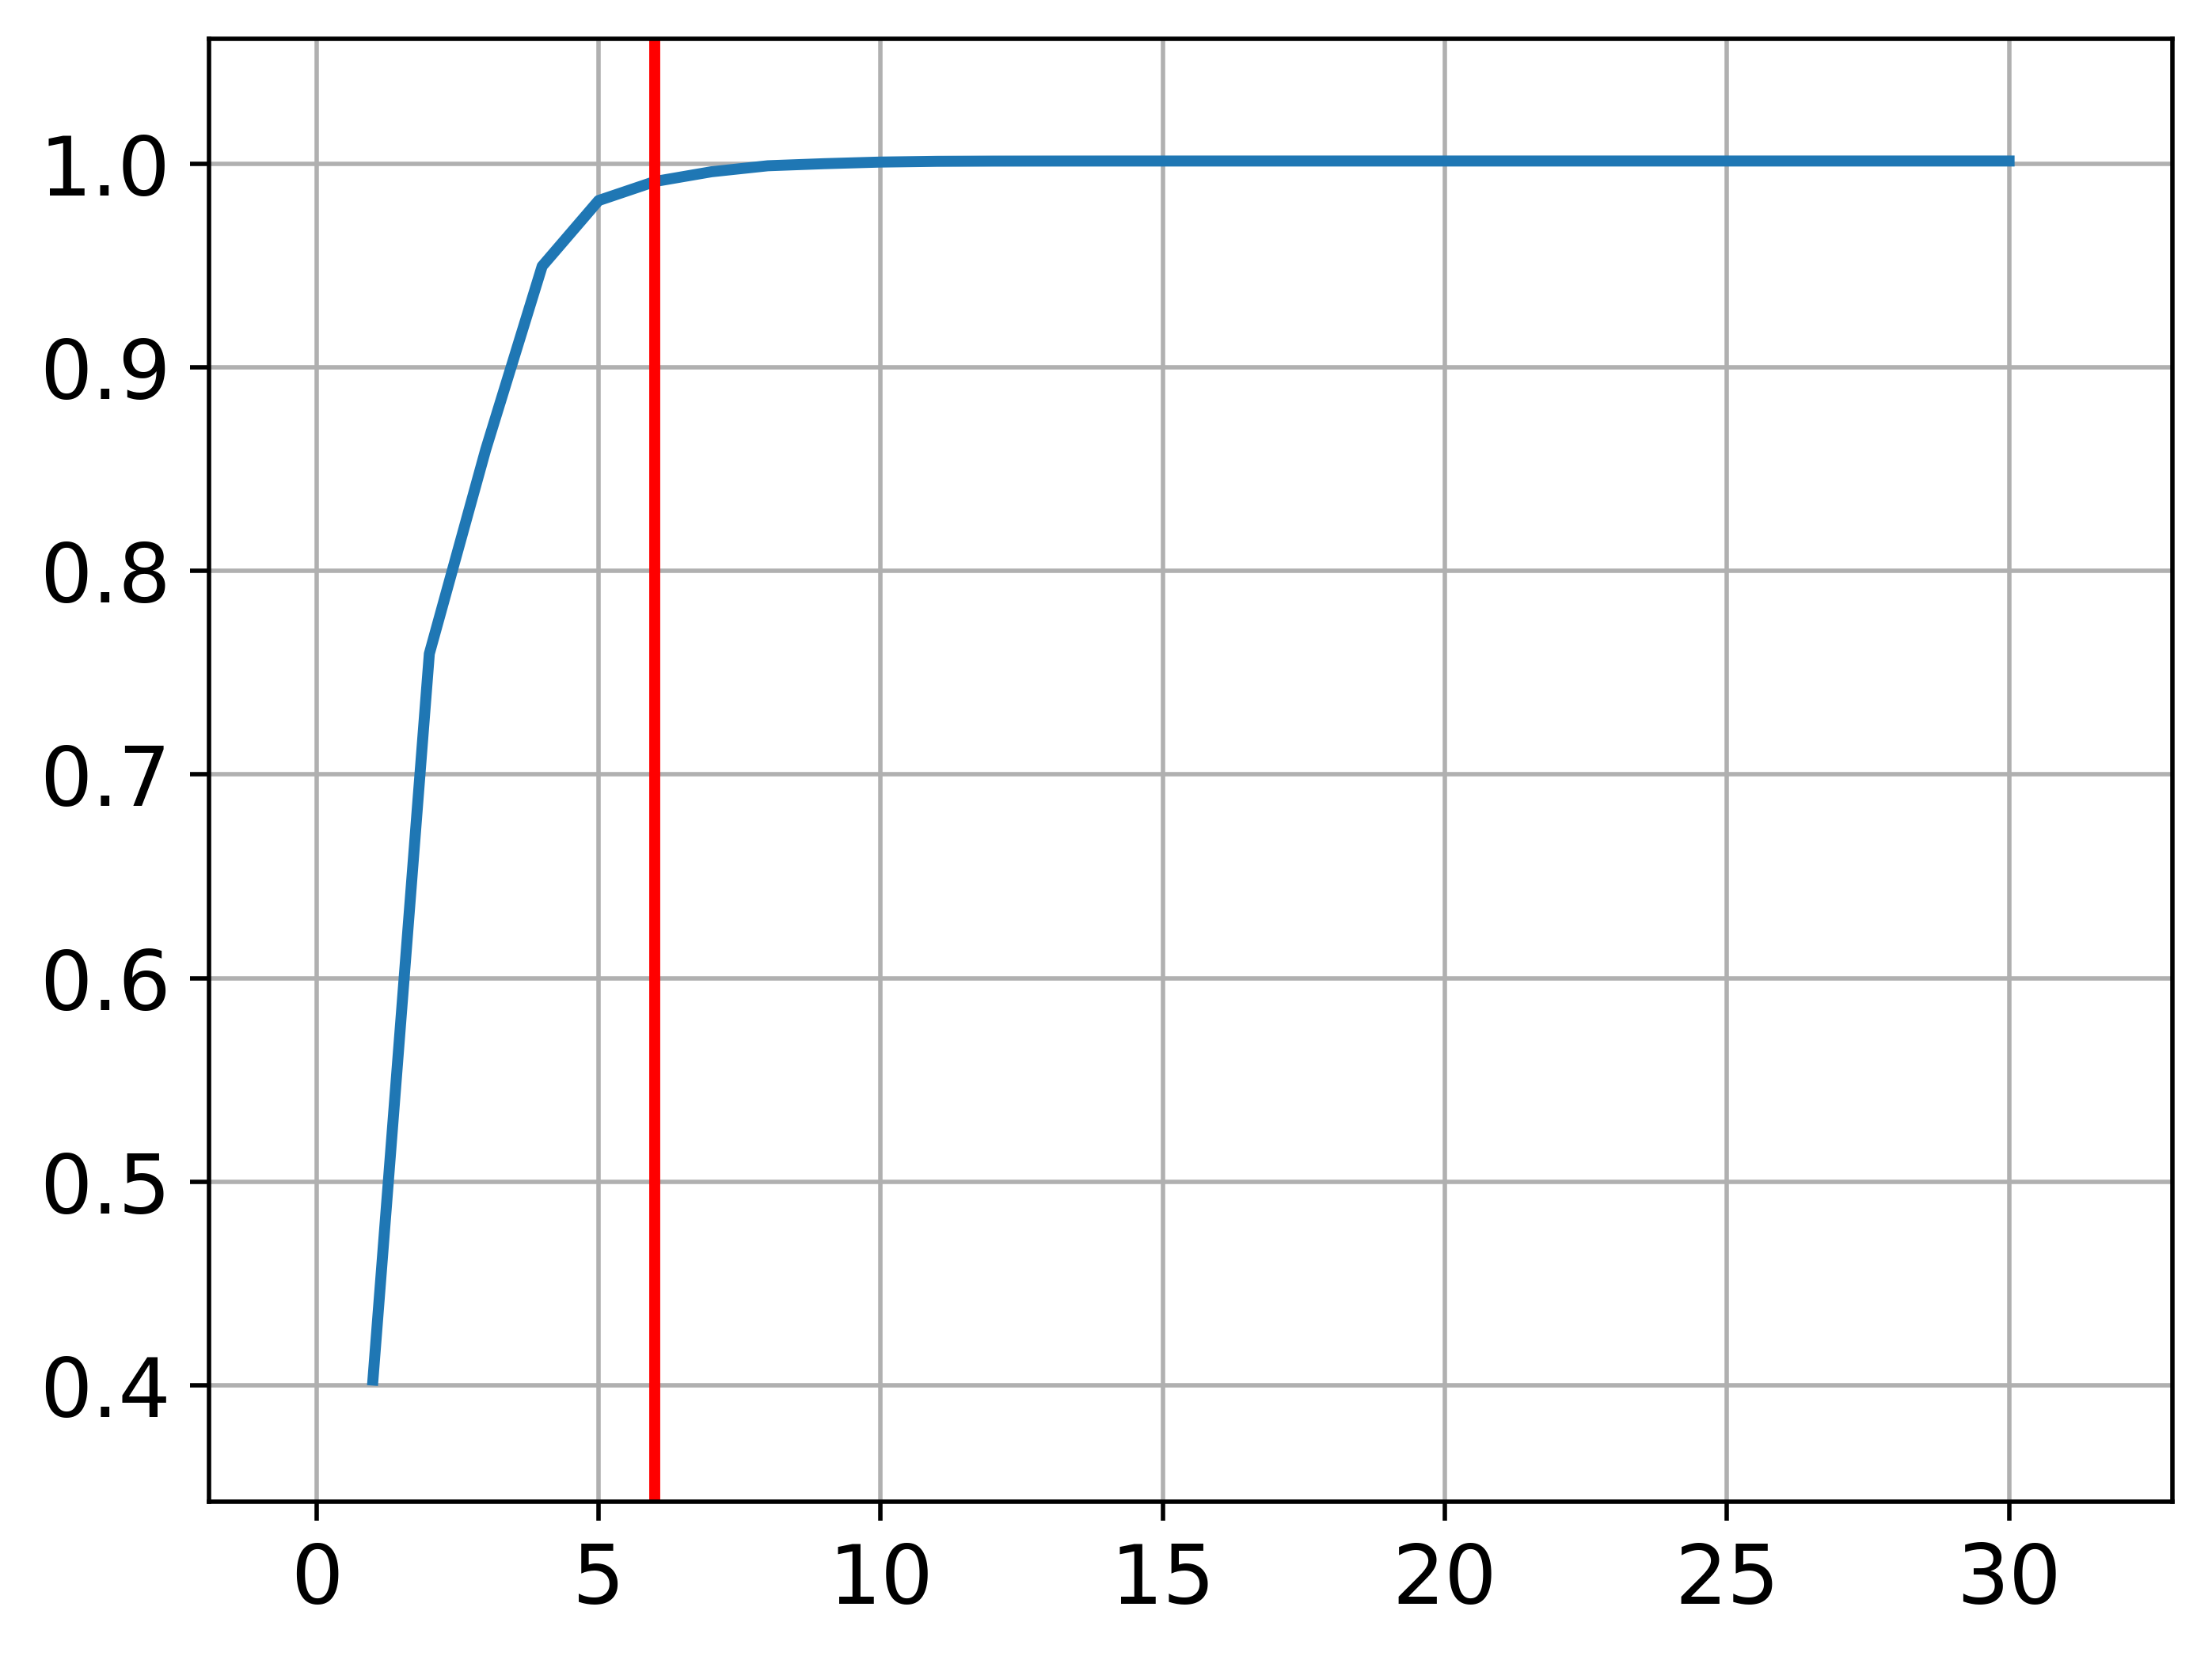

saving...
Estimating Gaussian KLD...
KLD:  143.91113735305765
train_stats:  (array([ -1.6706394,   5.2913857,   7.6526737,  24.087069 , -17.86036  ,
         3.4094644], dtype=float32), array([[14969.1273142 ,  -983.72473259,   281.47174238,   -32.01656599,
           51.99277899,    67.14890426],
       [ -983.72473259, 18588.01740622,  -690.96344871,   518.08010456,
          426.54536529,   563.24863376],
       [  281.47174238,  -690.96344871,  2834.29904275,  1006.77641356,
          637.84732535,   110.76436179],
       [  -32.01656599,   518.08010456,  1006.77641356,  3749.14884021,
         1331.51607038,  -206.27809957],
       [   51.99277899,   426.54536529,   637.84732535,  1331.51607038,
          560.95597705,    80.69758008],
       [   67.14890426,   563.24863376,   110.76436179,  -206.27809957,
           80.69758008,   520.23584226]]))
test_stats:  (array([  2.790498  ,  -6.2669306 , -10.202597  , -29.617607  ,
        22.932076  ,   0.53293276], dtype=float32), array

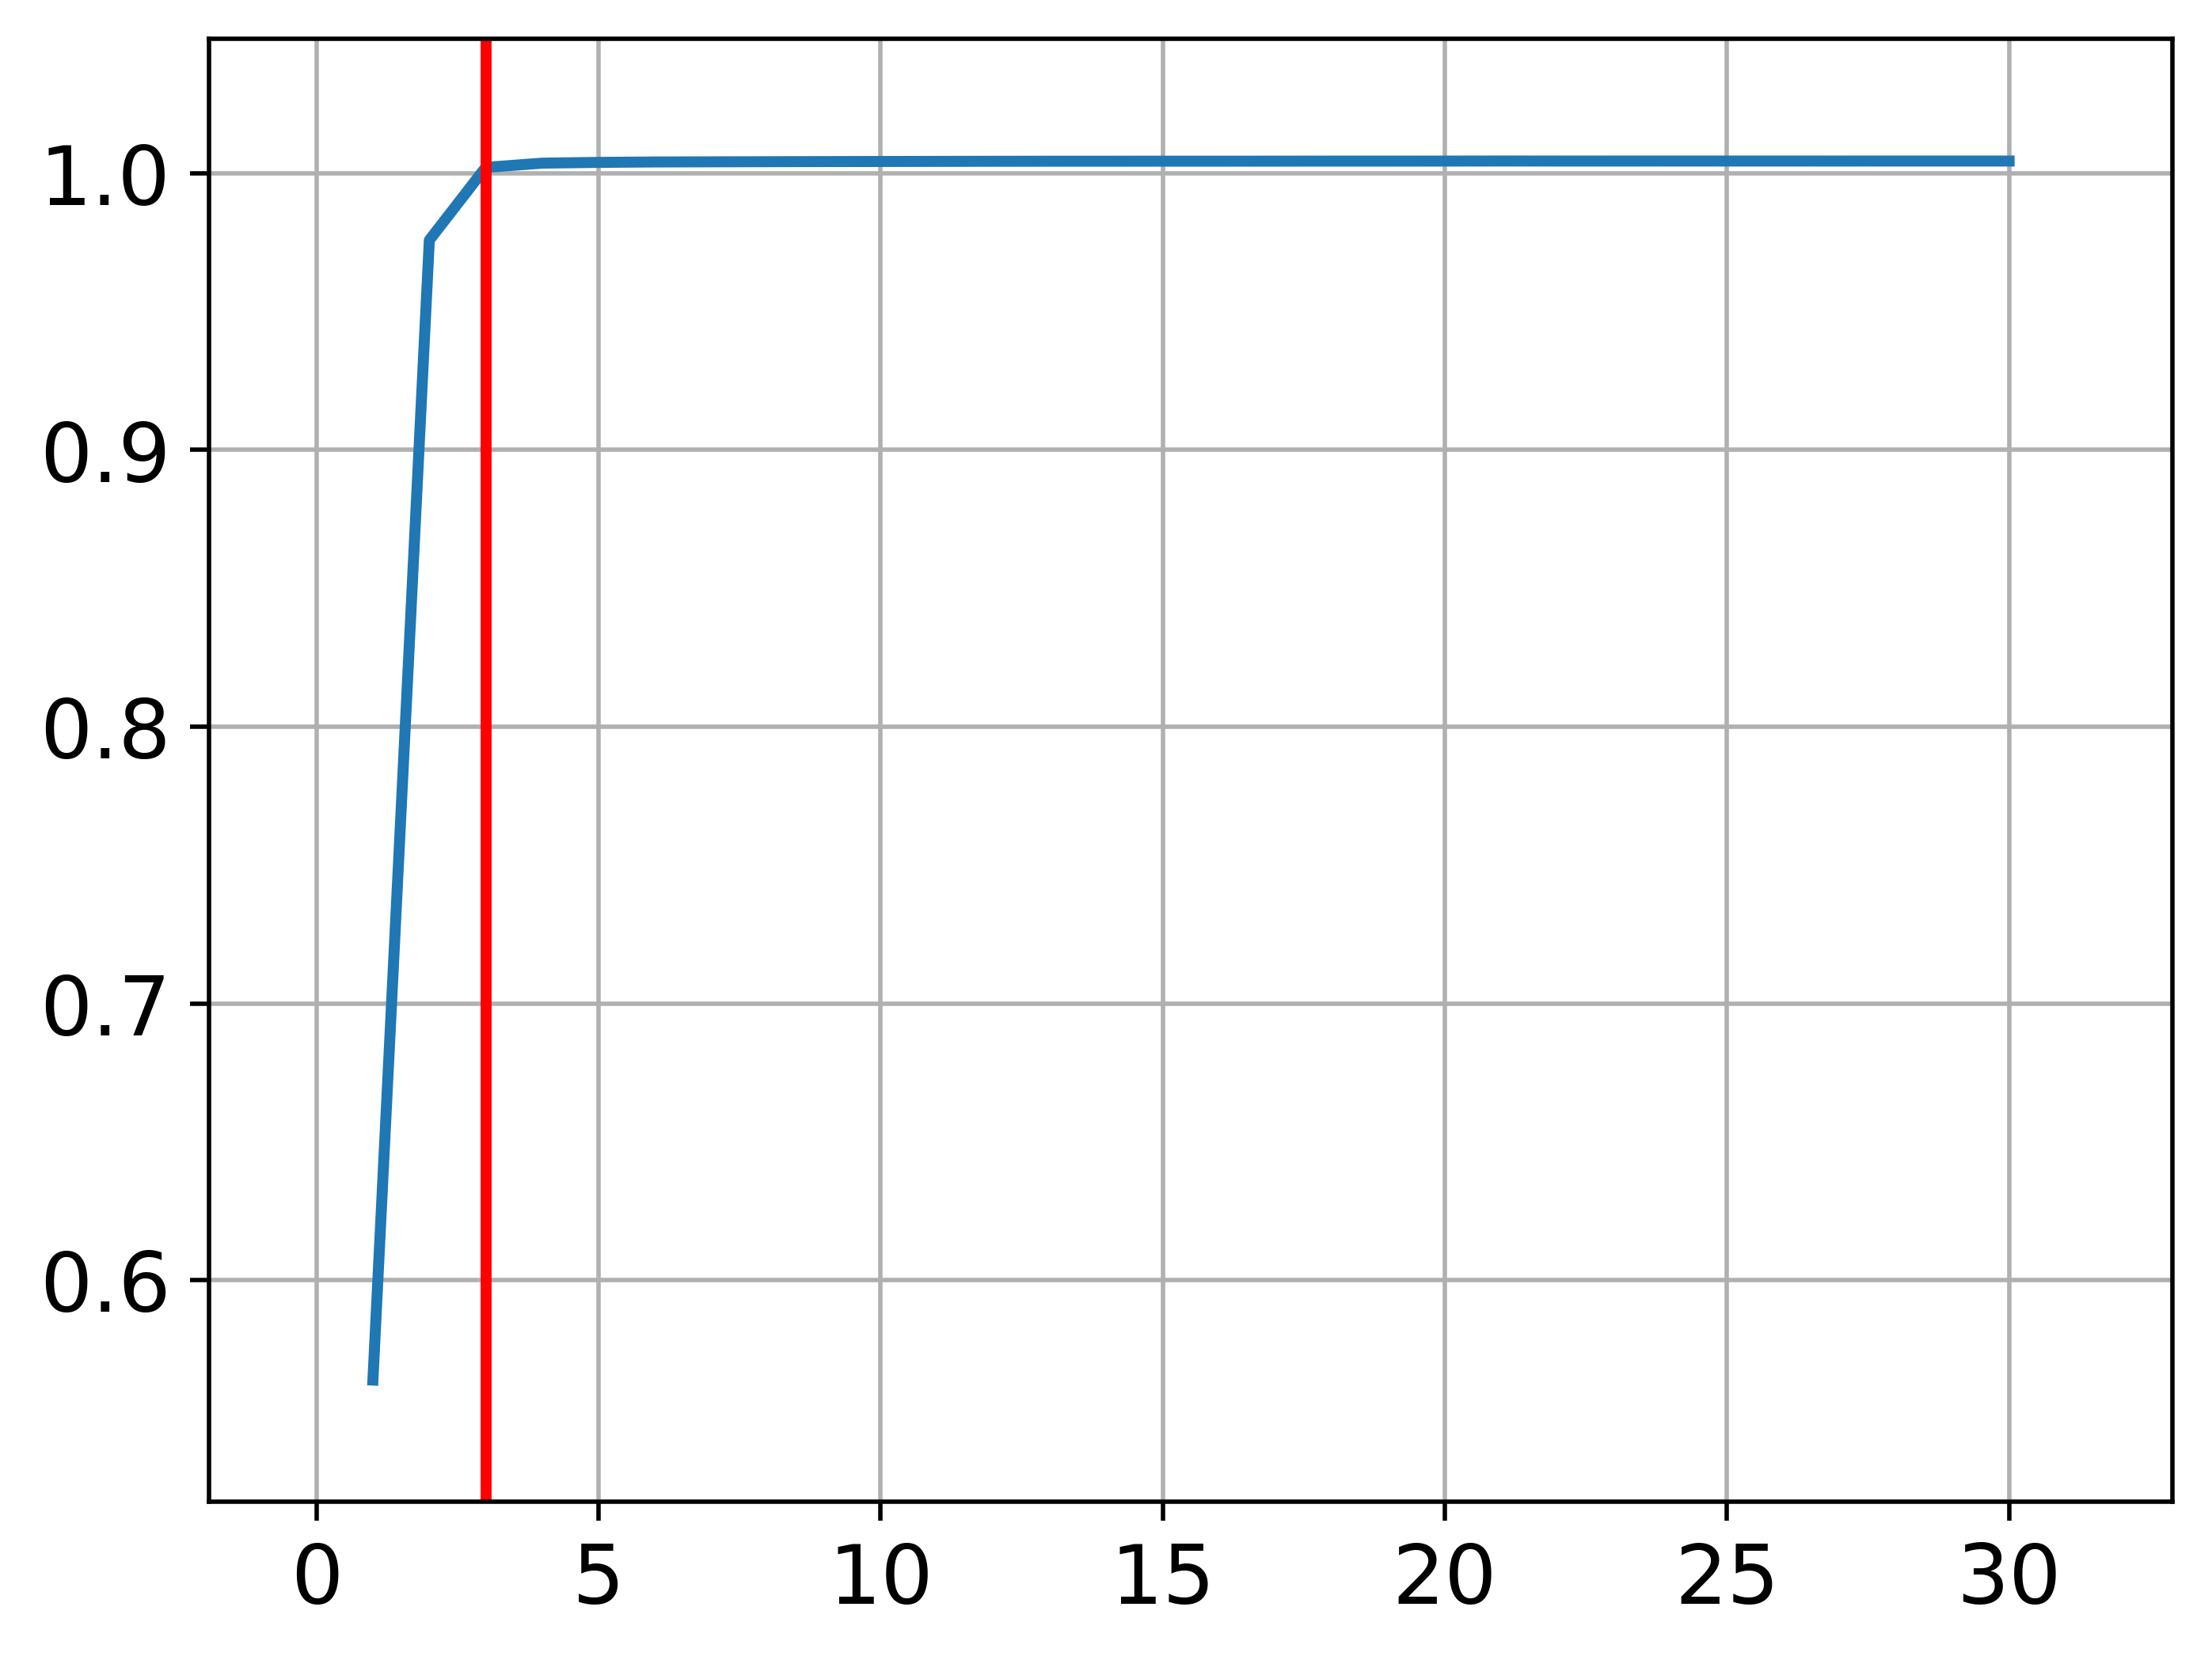

saving...
Estimating Gaussian KLD...
KLD:  29435002.34472411
train_stats:  (array([ 495.66153 , -616.5605  ,   -6.999958], dtype=float32), array([[6327710.98372842, 3214682.93128845,    6378.48975684],
       [3214682.93128845, 1633218.74950268,    7342.10296529],
       [   6378.48975684,    7342.10296529,  308617.87554935]]))
test_stats:  (array([-2633.7244  ,  2837.8337  ,    30.303812], dtype=float32), array([[ 3335442.36020827, -6557720.91382844,    65775.41939866],
       [-6557720.91382844, 12893316.61178328,  -142149.09780748],
       [   65775.41939866,  -142149.09780748,   467816.81027004]]))
done
KLD for SMD_machine-1-4
finding PCA...
(23706, 38) (23706,) (23707, 38) (23707,)
(23706, 38) (23706,) (22987, 38) (23707,)
(46693, 38)
Done!


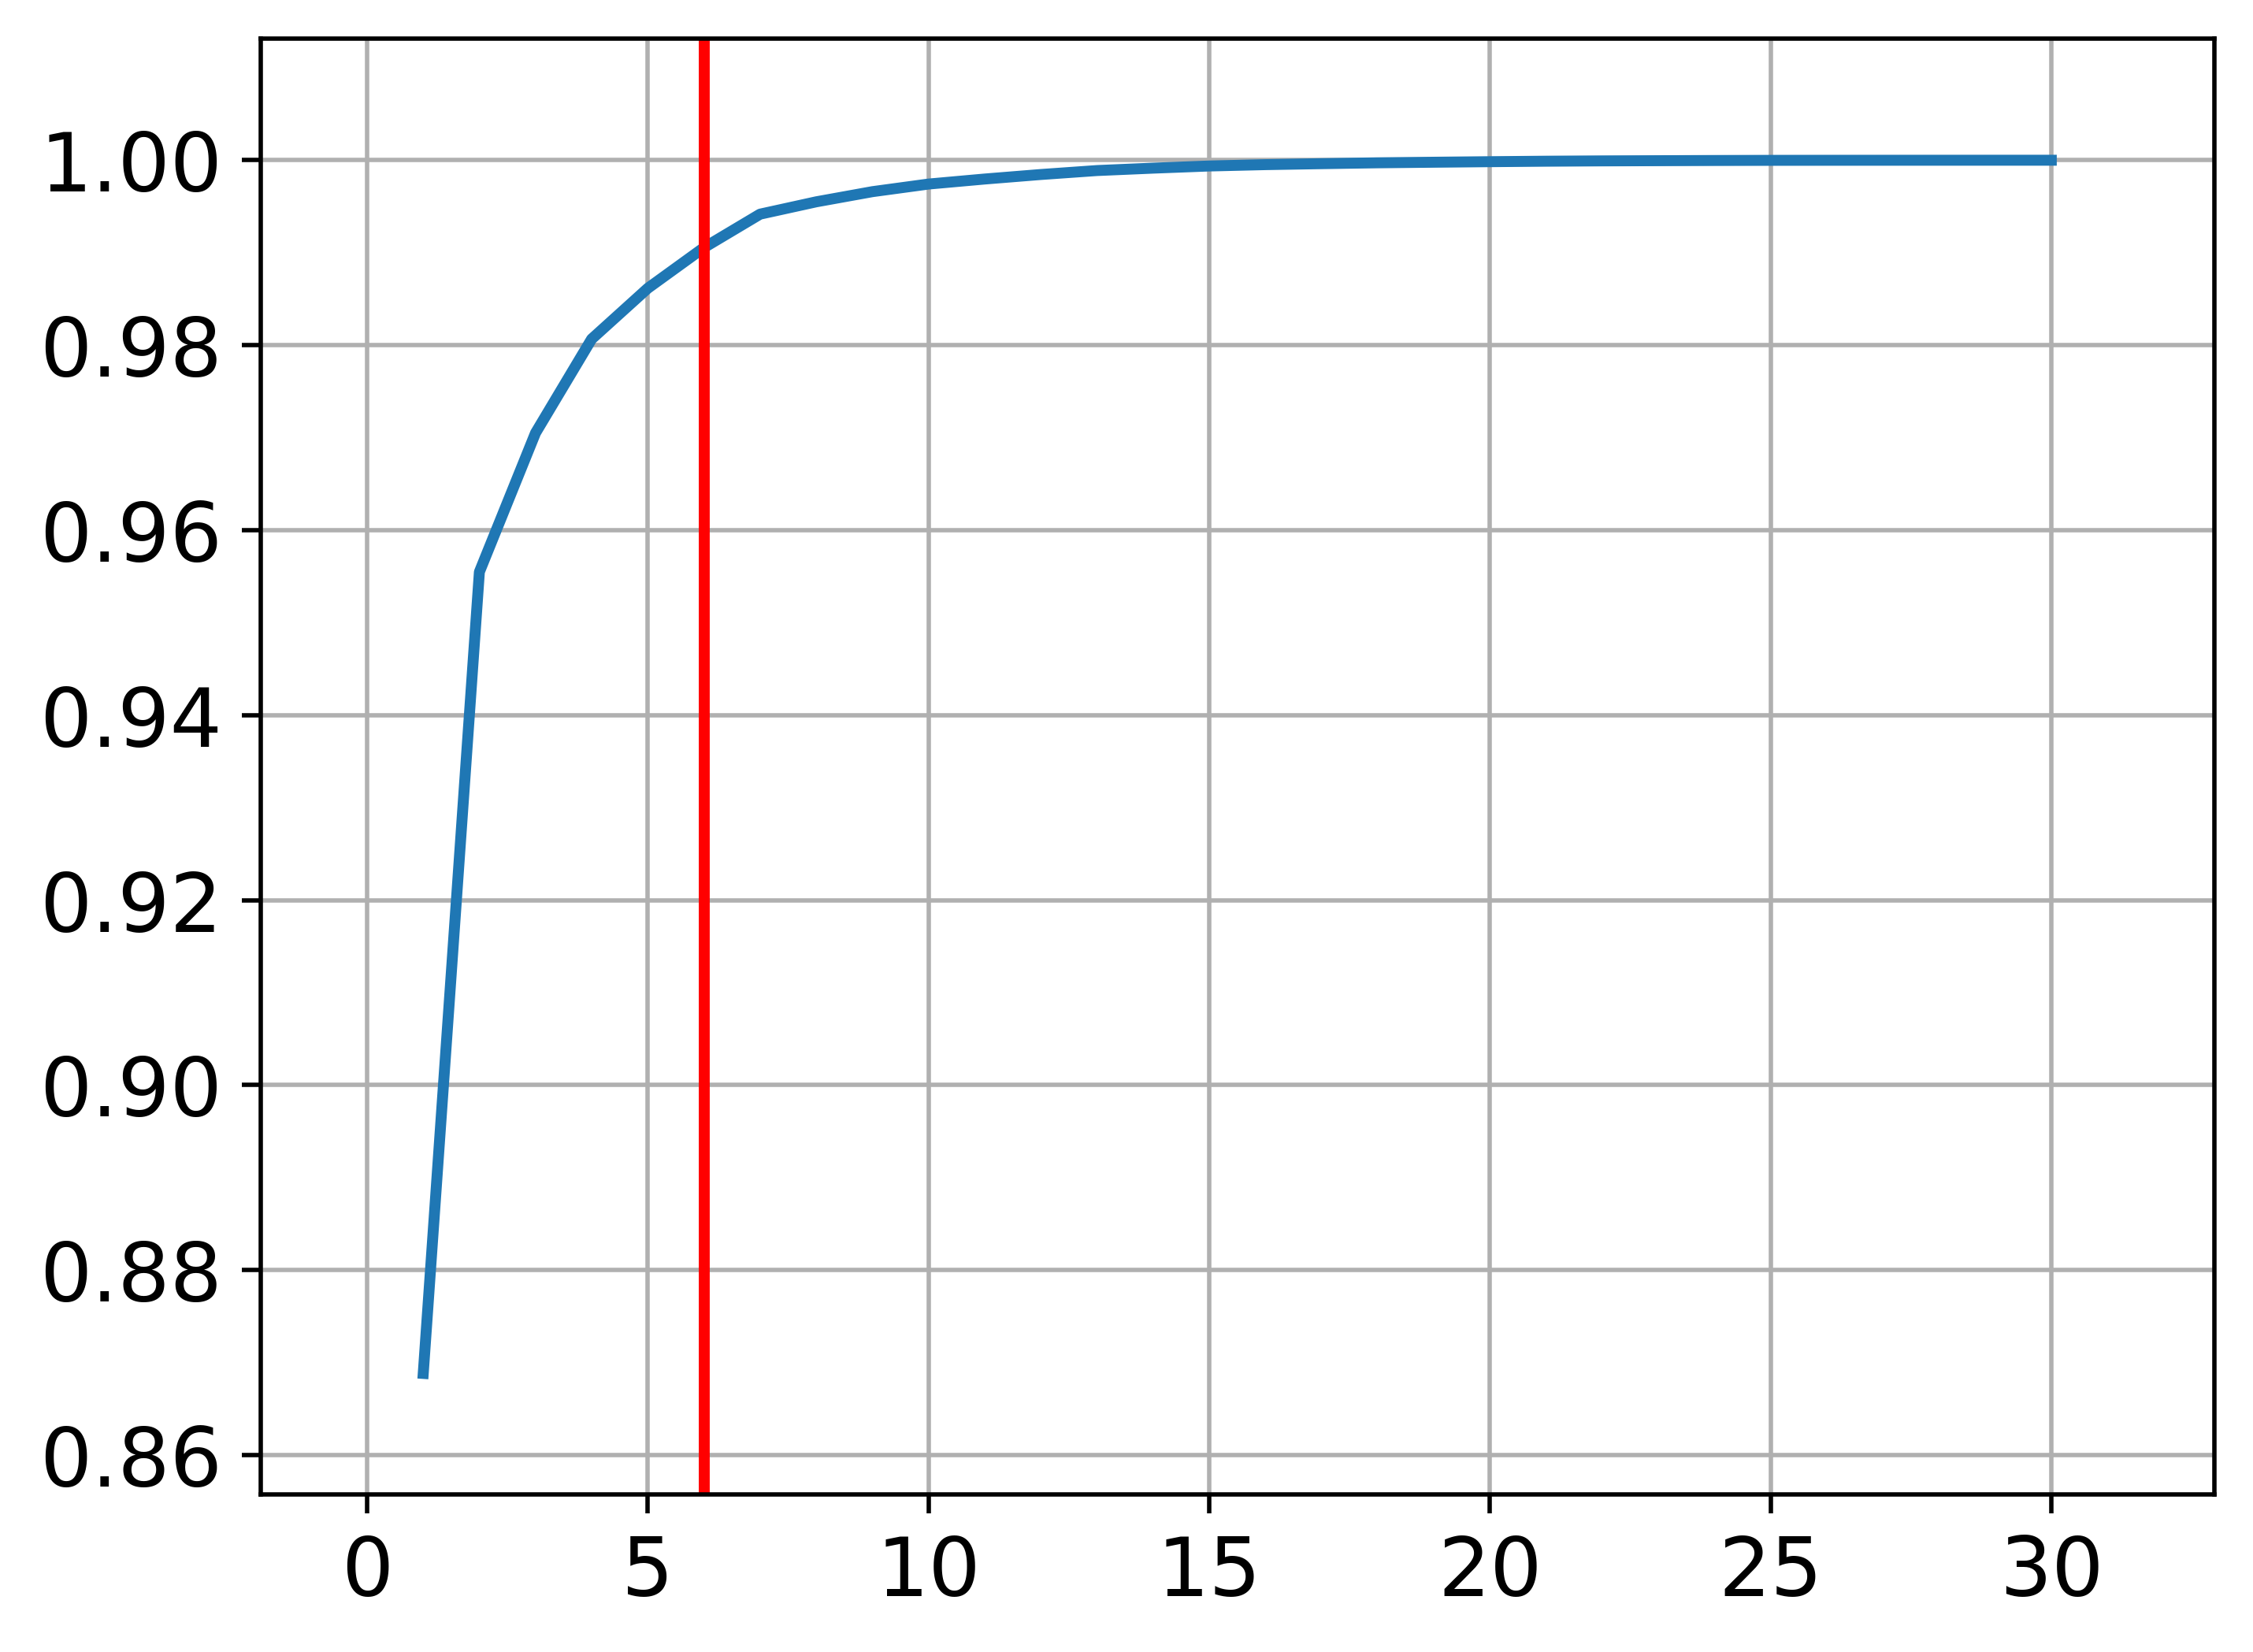

saving...
Estimating Gaussian KLD...
KLD:  130.35739449103855
train_stats:  (array([ 0.05024158, -0.1480585 ,  0.02299843, -0.00372194, -0.01595101,
        0.00779431], dtype=float32), array([[ 4.81363424e-01,  1.47818016e-02,  8.92173288e-03,
         8.18538096e-04, -3.98135382e-03, -3.51348060e-04],
       [ 1.47818016e-02,  2.78370596e-02, -5.20829438e-03,
        -1.99838553e-03, -3.37320057e-03,  1.39195023e-03],
       [ 8.92173288e-03, -5.20829438e-03,  1.74956372e-03,
        -5.58525993e-04,  5.03050746e-04, -2.55211041e-04],
       [ 8.18538096e-04, -1.99838553e-03, -5.58525993e-04,
         4.13520937e-03, -5.53716639e-04,  4.20542796e-04],
       [-3.98135382e-03, -3.37320057e-03,  5.03050746e-04,
        -5.53716639e-04,  1.87383205e-03,  9.96918741e-04],
       [-3.51348060e-04,  1.39195023e-03, -2.55211041e-04,
         4.20542796e-04,  9.96918741e-04,  3.61369617e-03]]))
test_stats:  (array([-0.05180904,  0.152721  , -0.0236252 ,  0.00387301,  0.01649695,
       -0.00

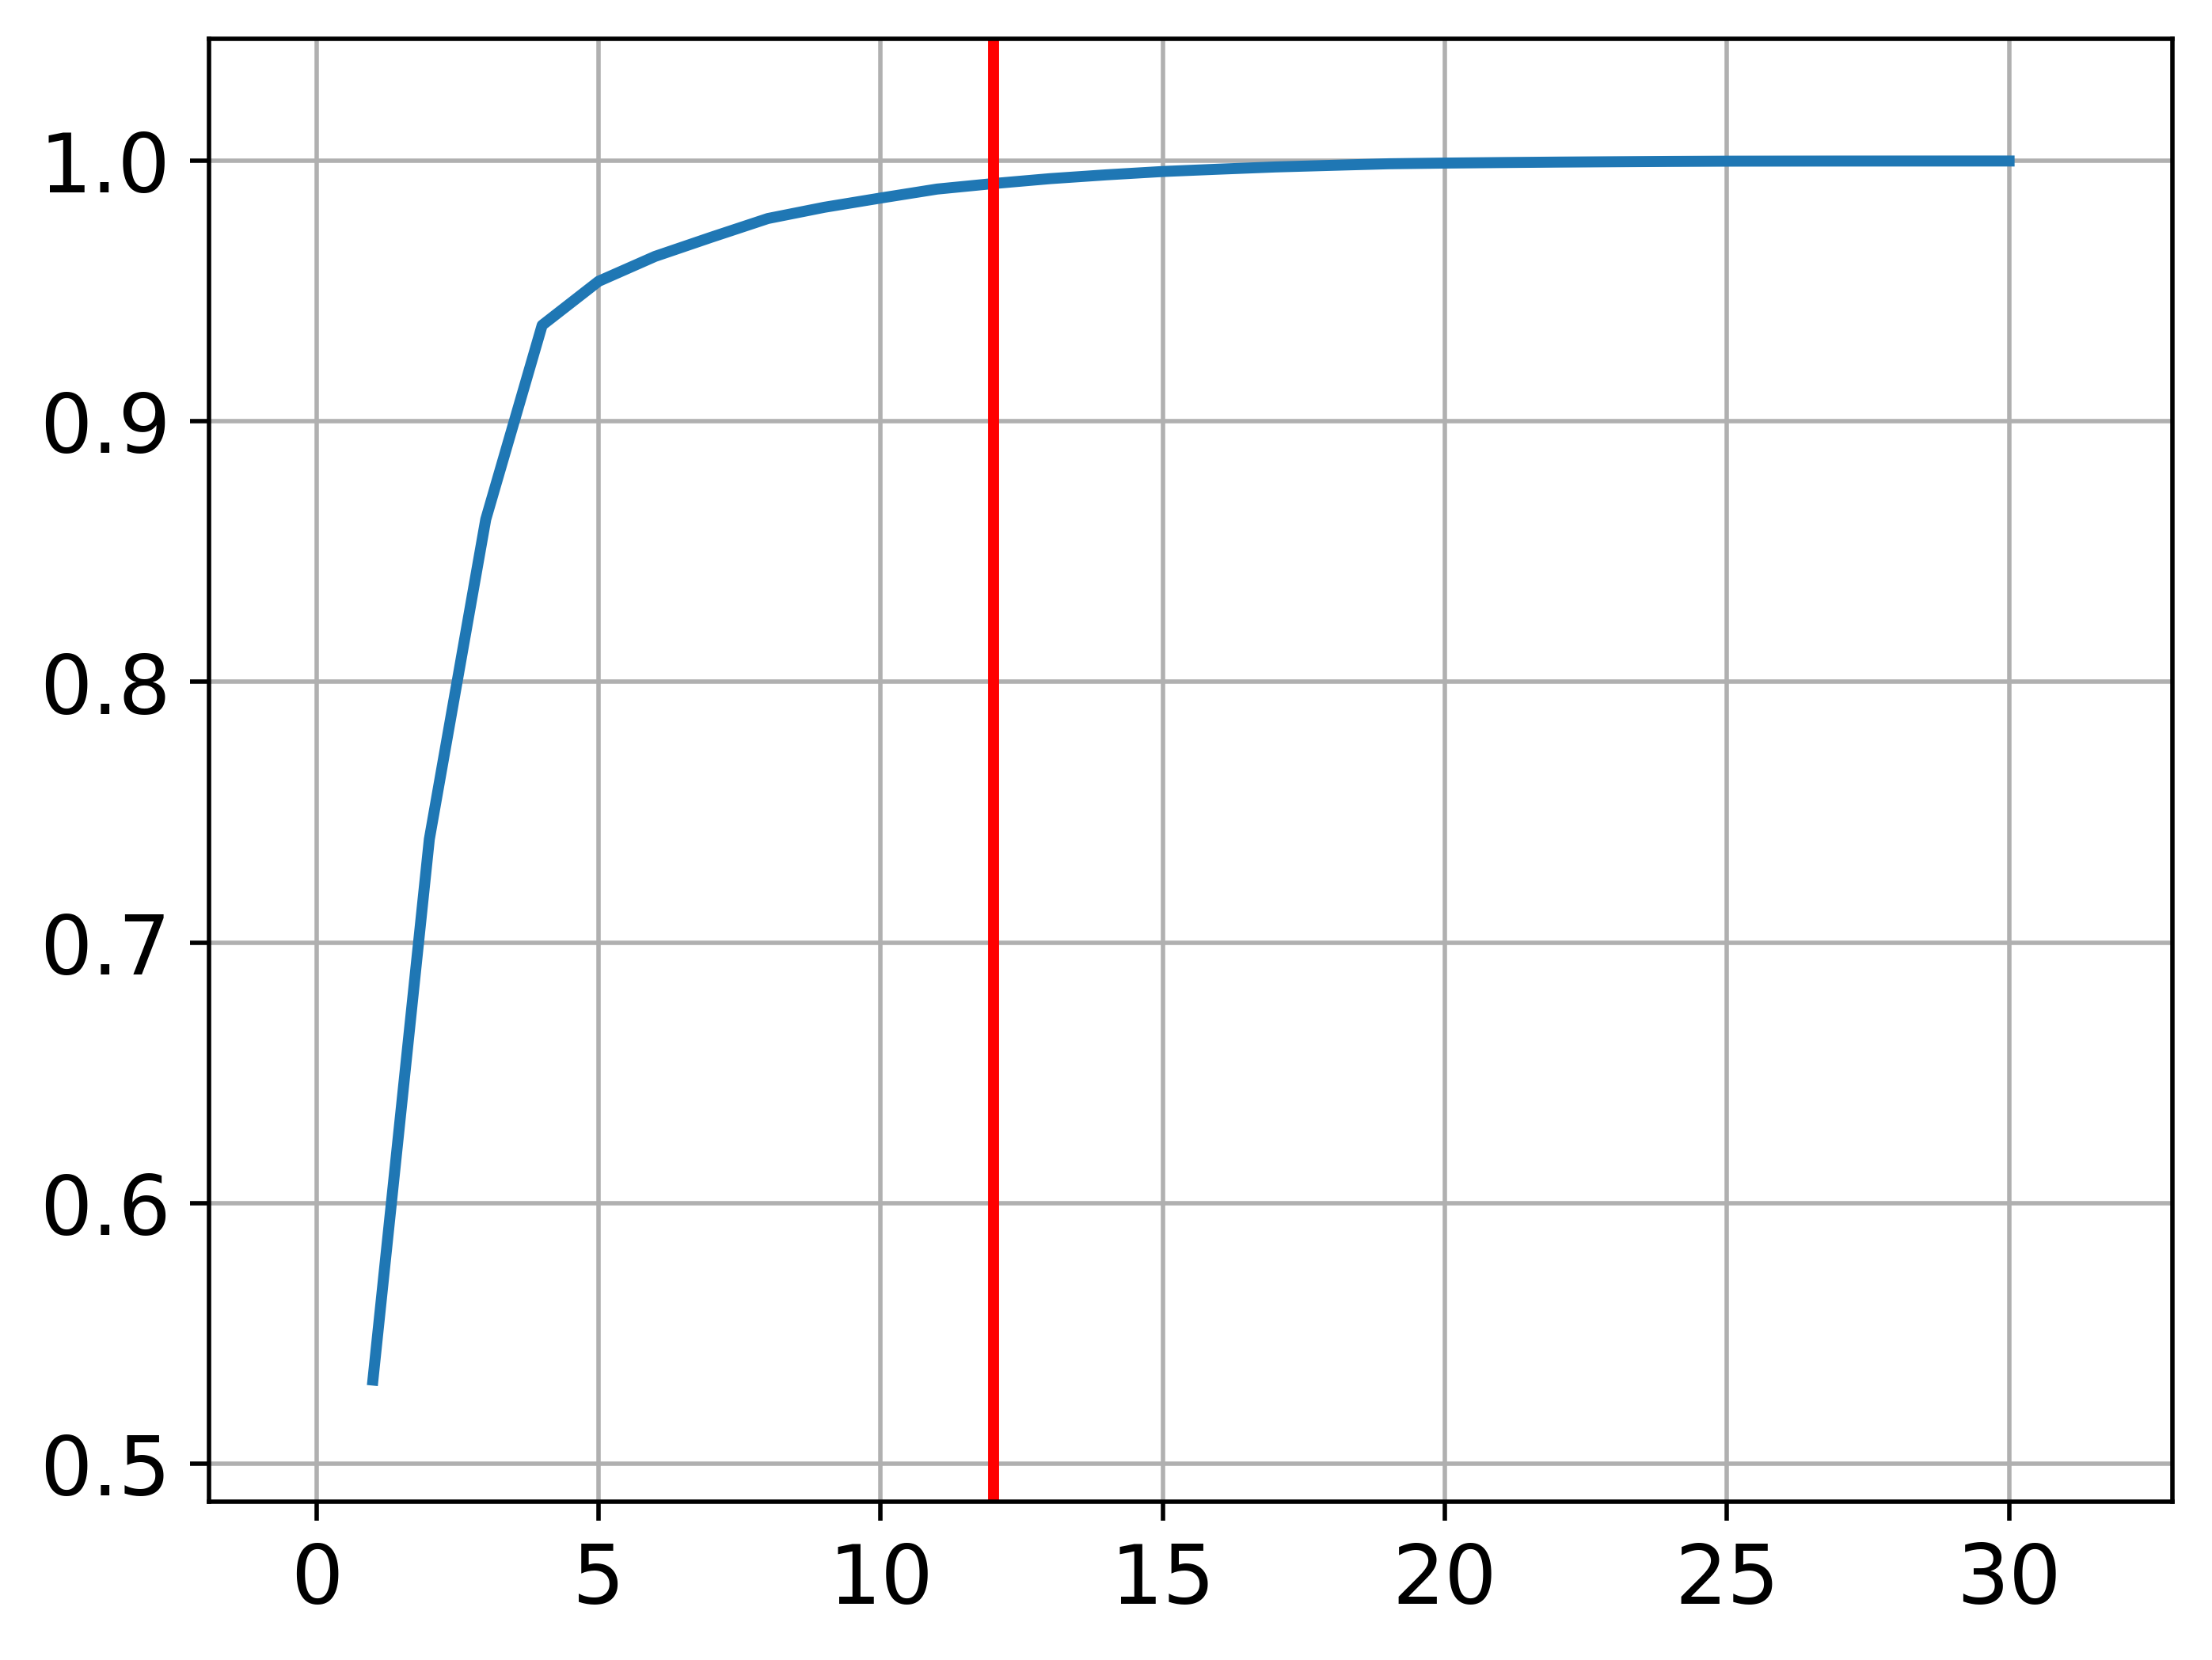

saving...
Estimating Gaussian KLD...
KLD:  6.233628830294819
train_stats:  (array([ 0.08673236, -0.00081188, -0.05250023, -0.01494729, -0.03642222,
        0.00286207, -0.00705901,  0.00197338,  0.00022318, -0.00135463,
       -0.00013998,  0.00061489], dtype=float32), array([[ 1.97652887e-01, -2.68201551e-03, -1.61360618e-02,
         5.72227479e-03,  1.18616928e-02,  4.53018829e-04,
        -1.43462579e-03, -1.05665861e-03, -4.24113343e-04,
         8.26478057e-05,  8.87471261e-05, -4.52688005e-04],
       [-2.68201551e-03,  6.62708838e-02,  2.48995264e-04,
         8.18501863e-04, -1.74463537e-04,  6.27167564e-05,
         1.78907066e-04, -1.81556025e-04, -1.01728326e-04,
        -5.44745522e-05,  4.47082209e-05, -7.90289212e-05],
       [-1.61360618e-02,  2.48995264e-04,  4.30337344e-02,
        -5.39603351e-05, -3.91526069e-03,  5.05160481e-04,
        -1.70655737e-04,  2.10563046e-04, -6.14201118e-05,
        -2.83003656e-04, -7.55840906e-05,  3.31367849e-05],
       [ 5.72227479

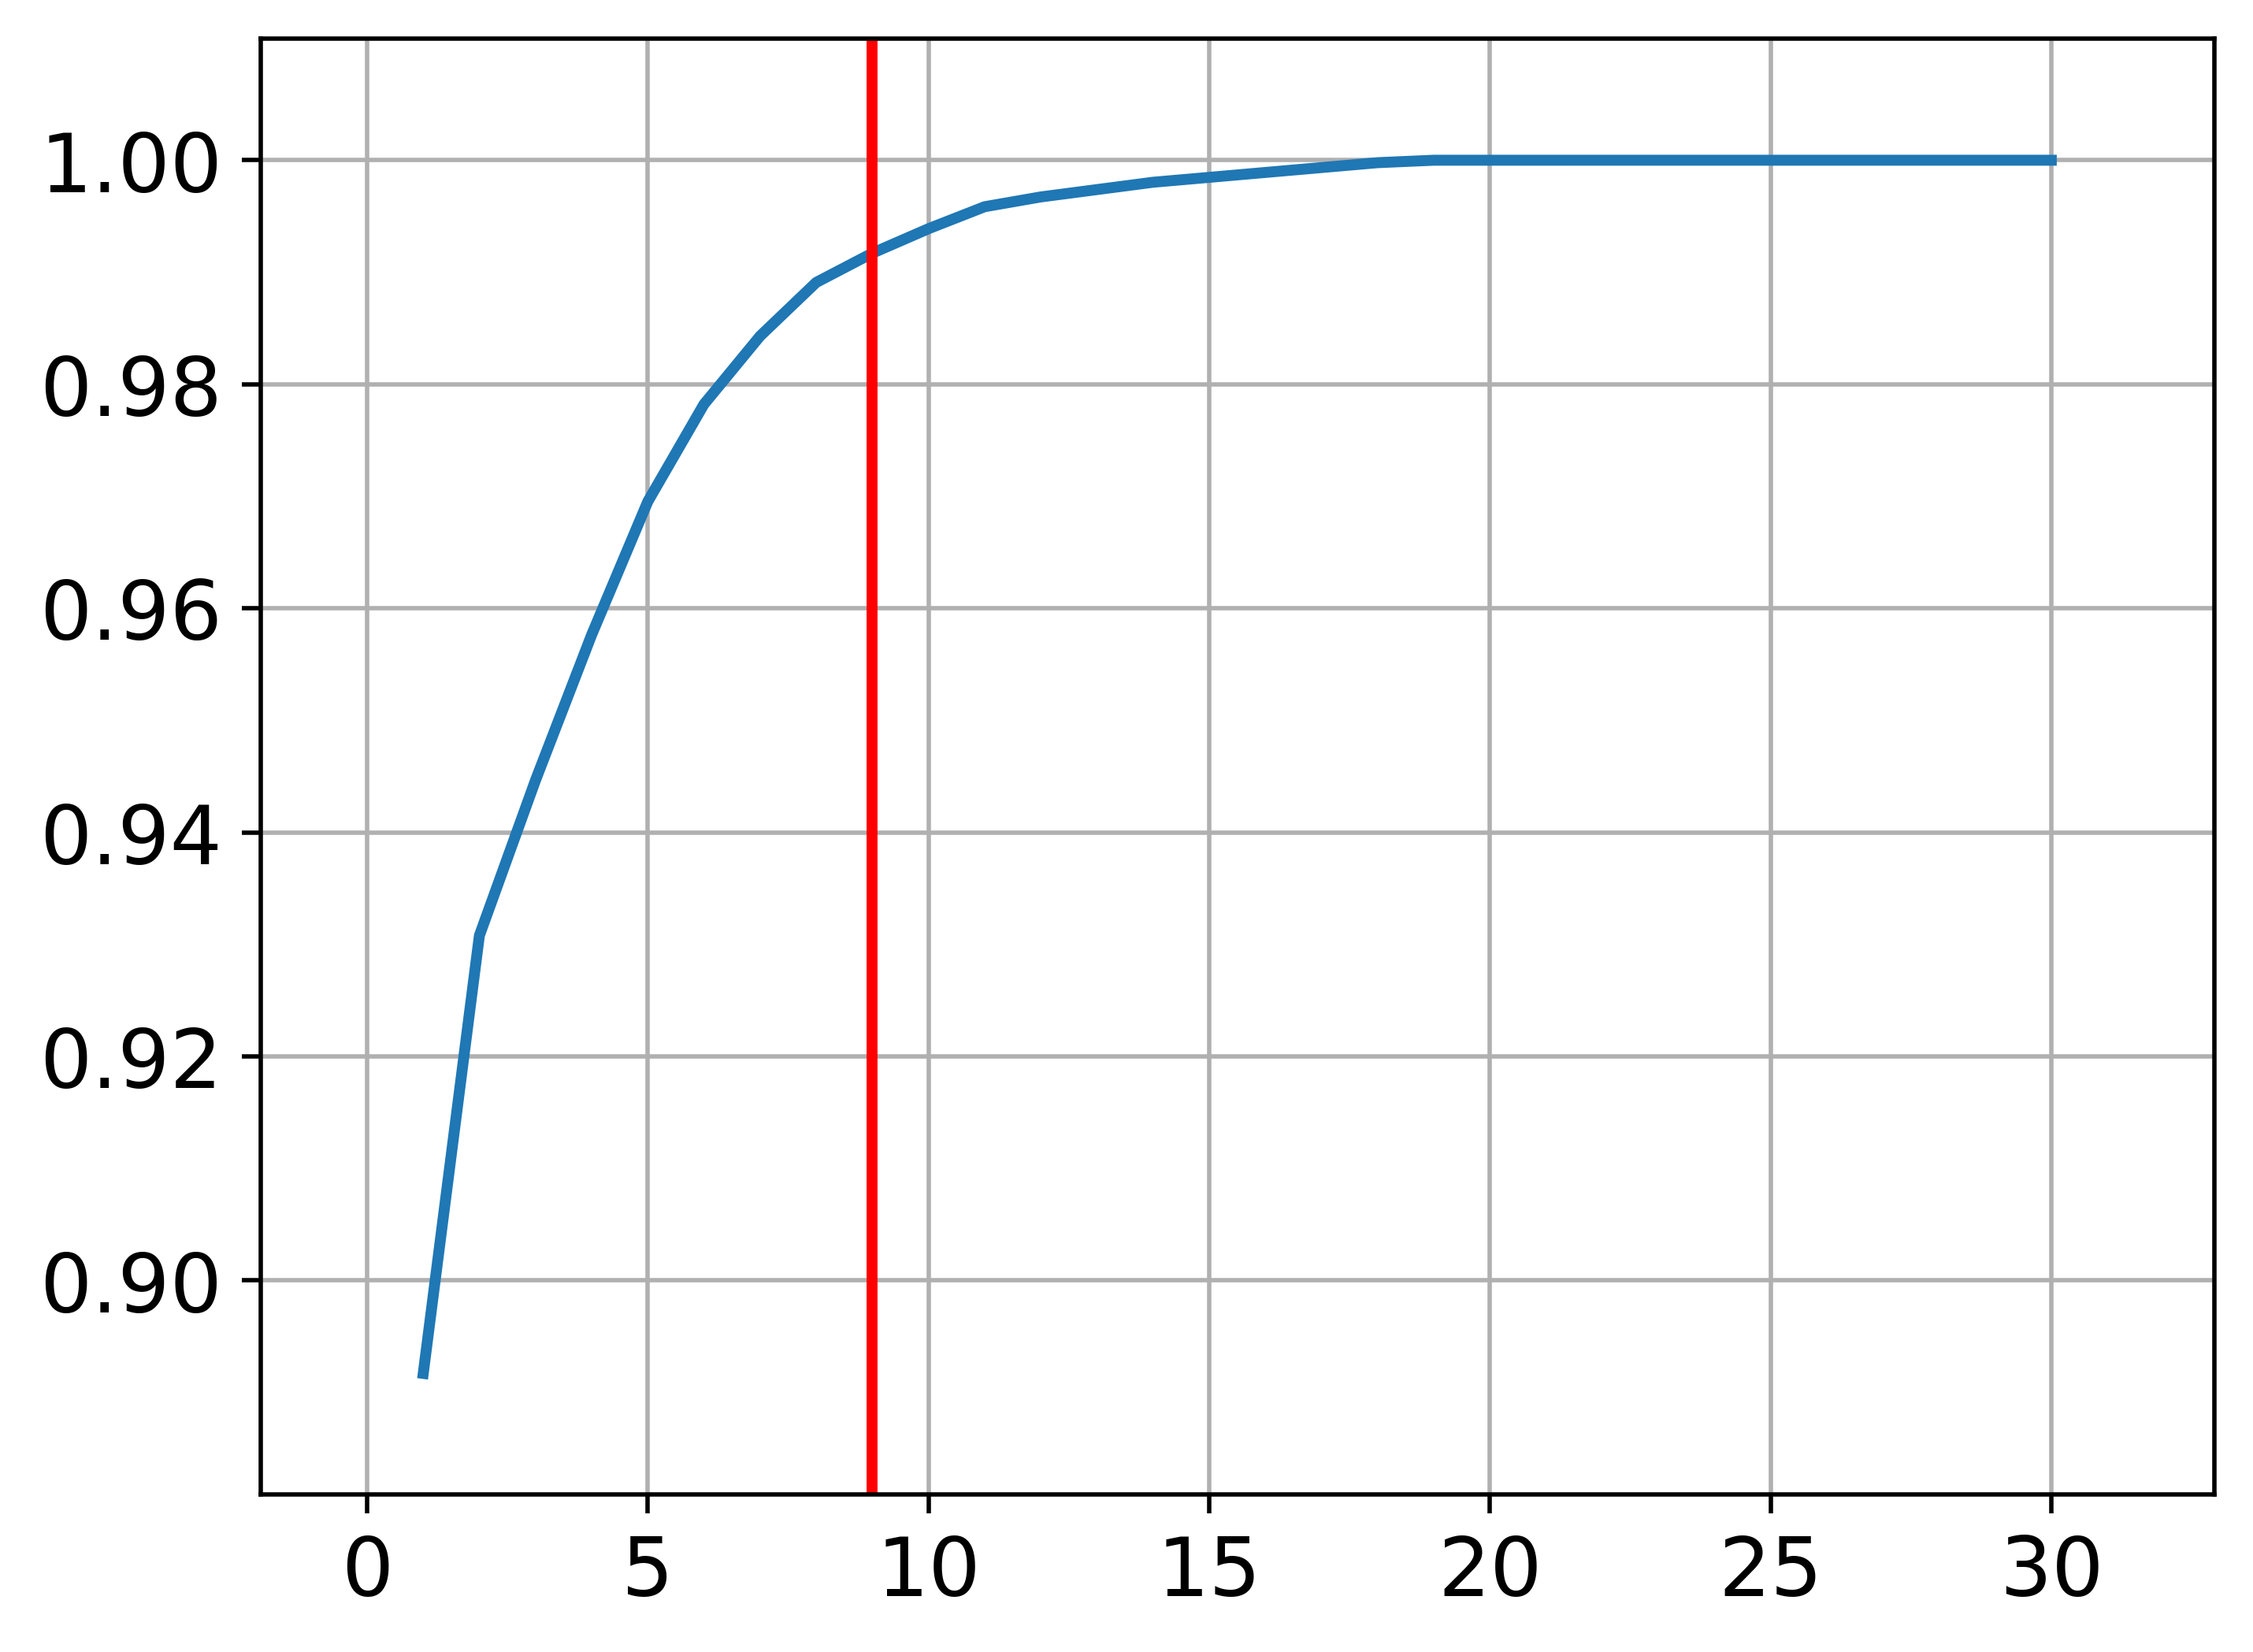

saving...
Estimating Gaussian KLD...
KLD:  743.2548433430086
train_stats:  (array([-4.3744171e-01,  7.4432720e-04,  2.5386675e-04, -4.2301367e-04,
        1.2056662e-03, -1.1084889e-03, -7.5301365e-04, -1.7610080e-04,
        8.4817637e-04], dtype=float32), array([[ 1.30069551e-03, -4.31171298e-04, -8.92600485e-05,
        -3.51026749e-04, -3.03785390e-04, -2.18346994e-05,
         1.09428525e-05, -1.17632309e-04,  1.05866042e-06],
       [-4.31171298e-04,  2.82373191e-02, -6.94117855e-06,
         1.52891839e-05, -2.93815255e-05,  3.60589206e-05,
         1.74678076e-05,  4.71706172e-06, -4.32521323e-05],
       [-8.92600485e-05, -6.94117855e-06,  9.95837980e-03,
         6.89308676e-05, -3.21283360e-05,  2.36615182e-05,
         8.27784765e-06,  2.17610256e-06, -1.45160451e-05],
       [-3.51026749e-04,  1.52891839e-05,  6.89308676e-05,
         8.90331722e-03, -1.23192490e-04,  2.33227437e-05,
         7.72381098e-06,  1.33824894e-06, -1.68326864e-05],
       [-3.03785390e-04, -2.93

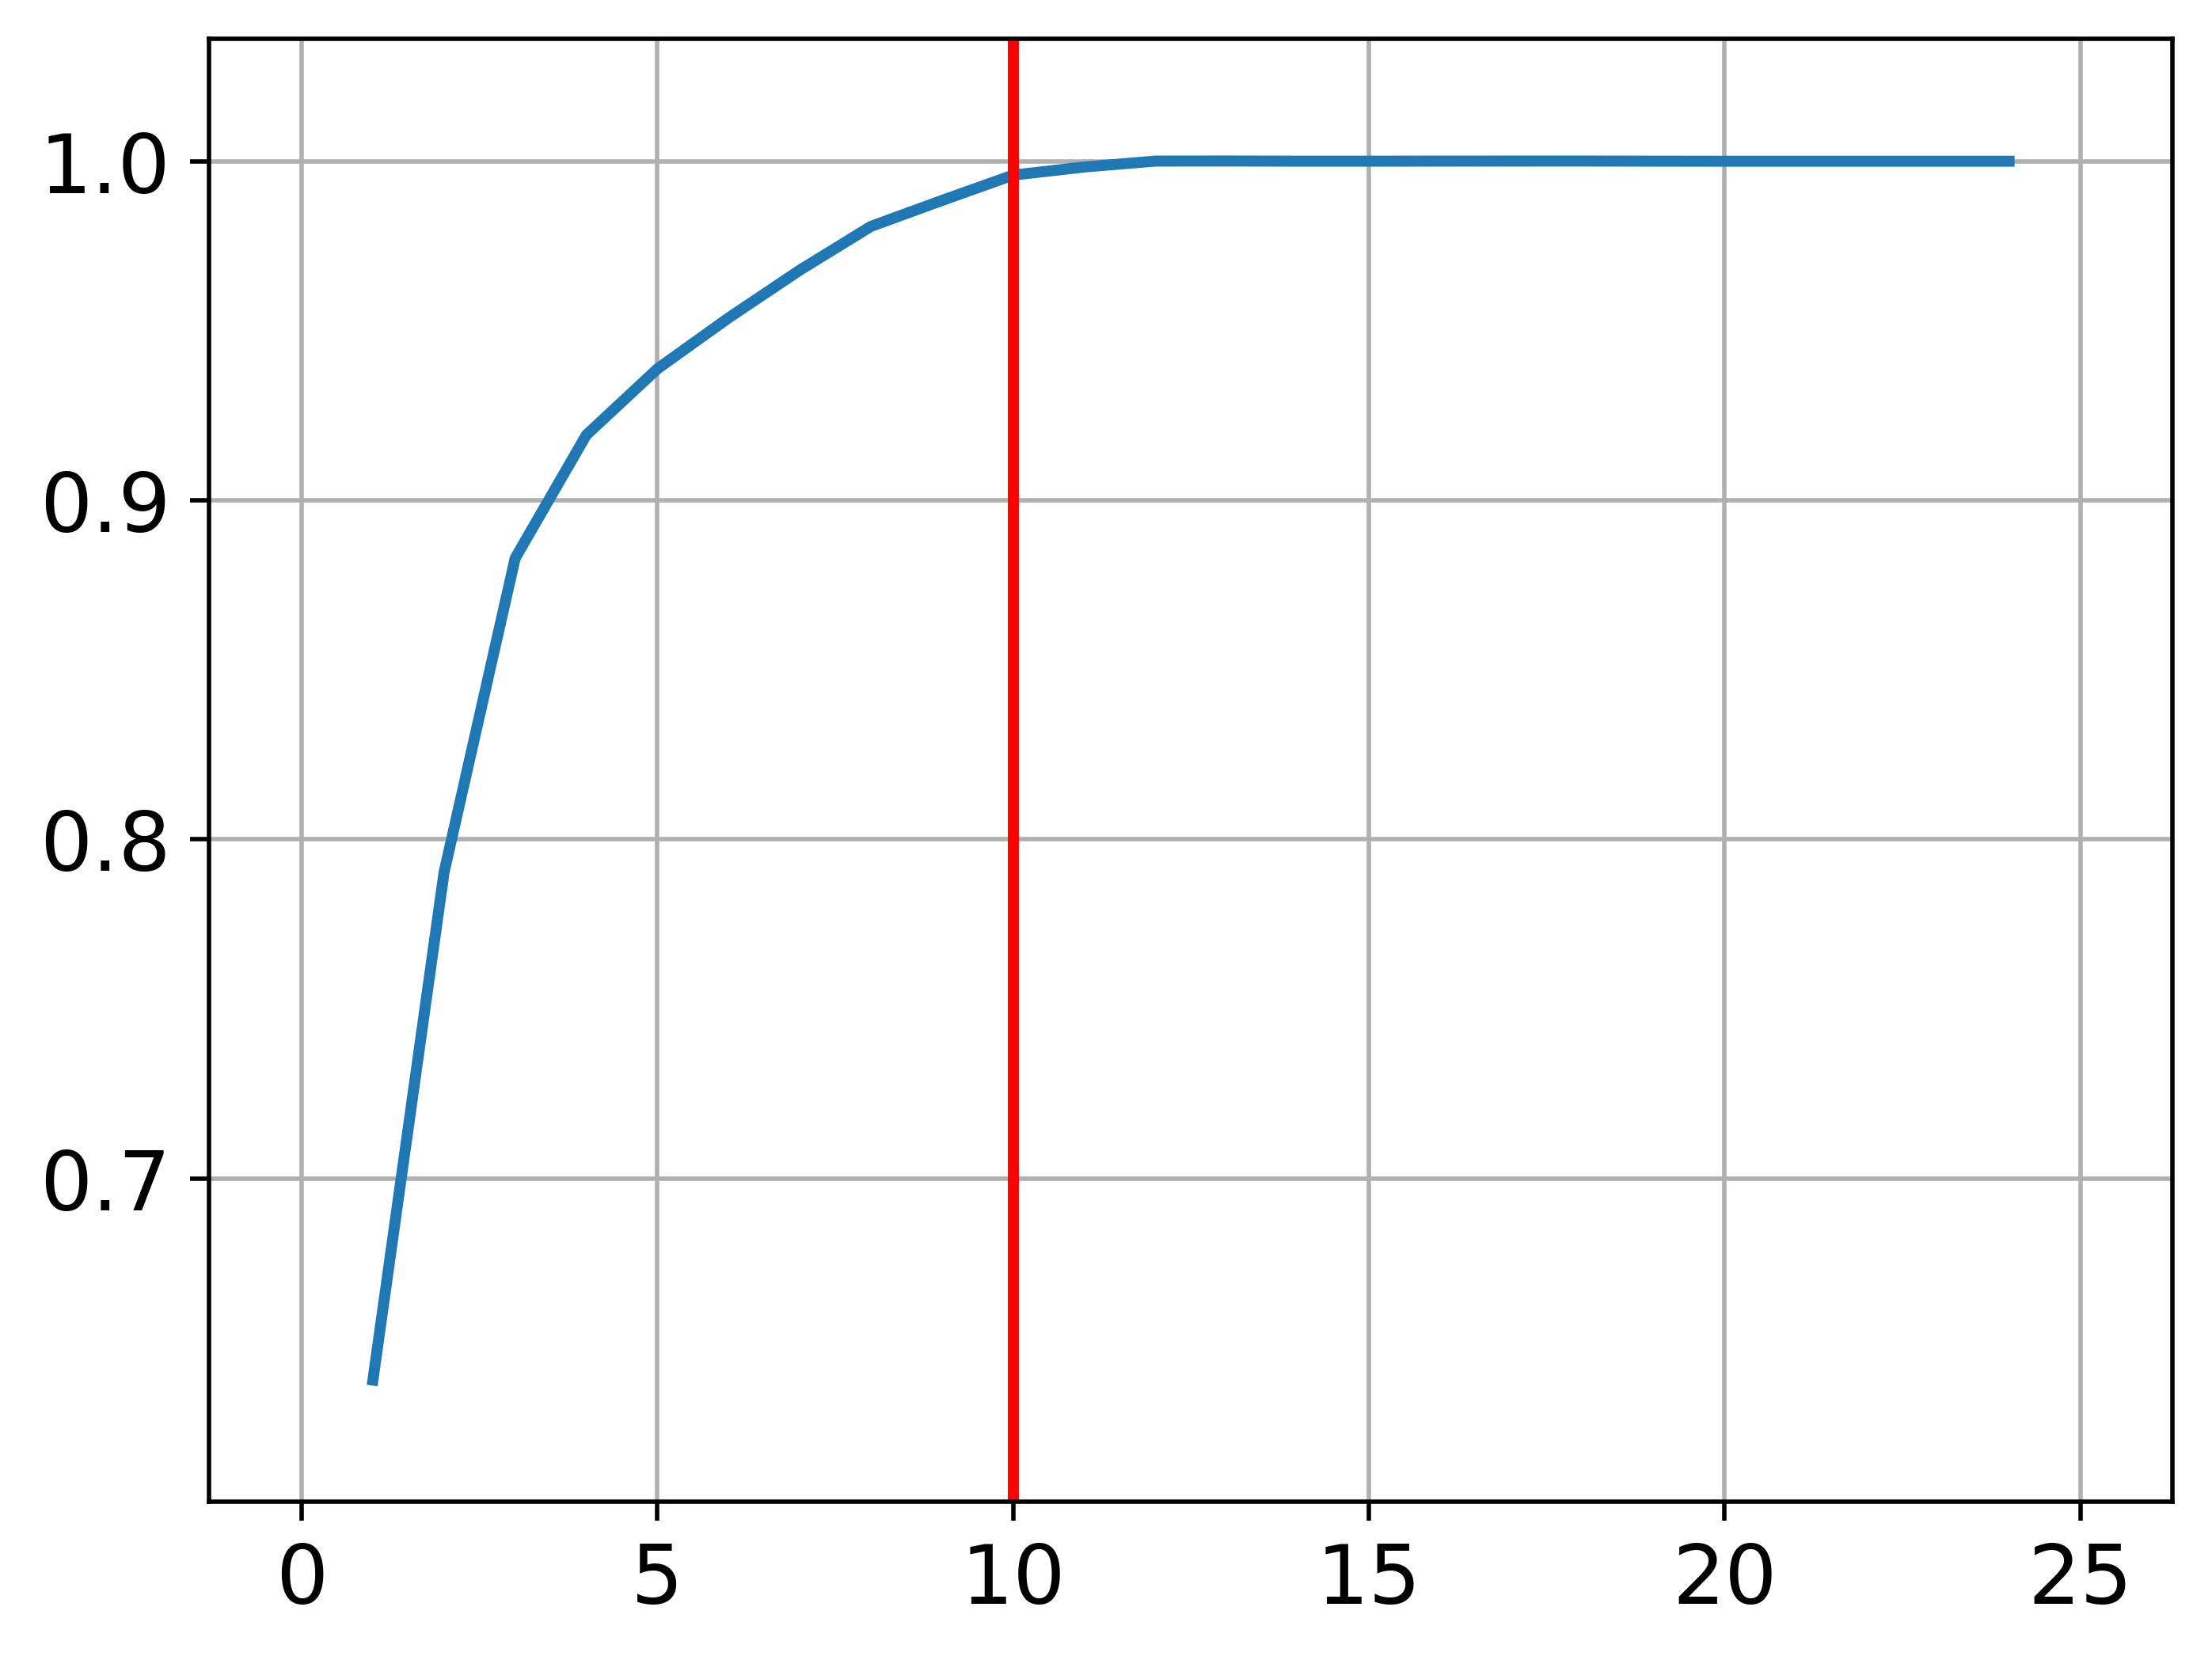

saving...
Estimating Gaussian KLD...
KLD:  2.9273418877903516
train_stats:  (array([ 1.43659245e-02,  1.22841960e-03, -1.21431985e-04,  1.61349063e-03,
        4.67979291e-04,  2.40613736e-04,  2.93663034e-04,  5.80249725e-05,
       -2.21085921e-03,  1.50551635e-03], dtype=float32), array([[ 3.49962880e-02,  1.56216078e-04, -6.56091896e-04,
         2.14535082e-04, -3.08887084e-04,  2.38109427e-04,
        -7.23296649e-06, -2.76121271e-04,  1.18646199e-06,
        -9.58349178e-05],
       [ 1.56216078e-04,  8.50055555e-03,  1.71895351e-04,
         1.68261716e-04,  7.88911250e-06, -1.59212031e-05,
        -3.75012295e-07, -2.97700349e-04, -6.80835917e-05,
        -8.66352666e-05],
       [-6.56091896e-04,  1.71895351e-04,  5.22574780e-03,
        -1.24816100e-05,  1.05163869e-04, -5.40078729e-05,
        -5.67313194e-08, -2.43414685e-05, -7.61600807e-06,
        -1.46394620e-05],
       [ 2.14535082e-04,  1.68261716e-04, -1.24816100e-05,
         2.35562009e-03,  5.81966994e-04,  1.76

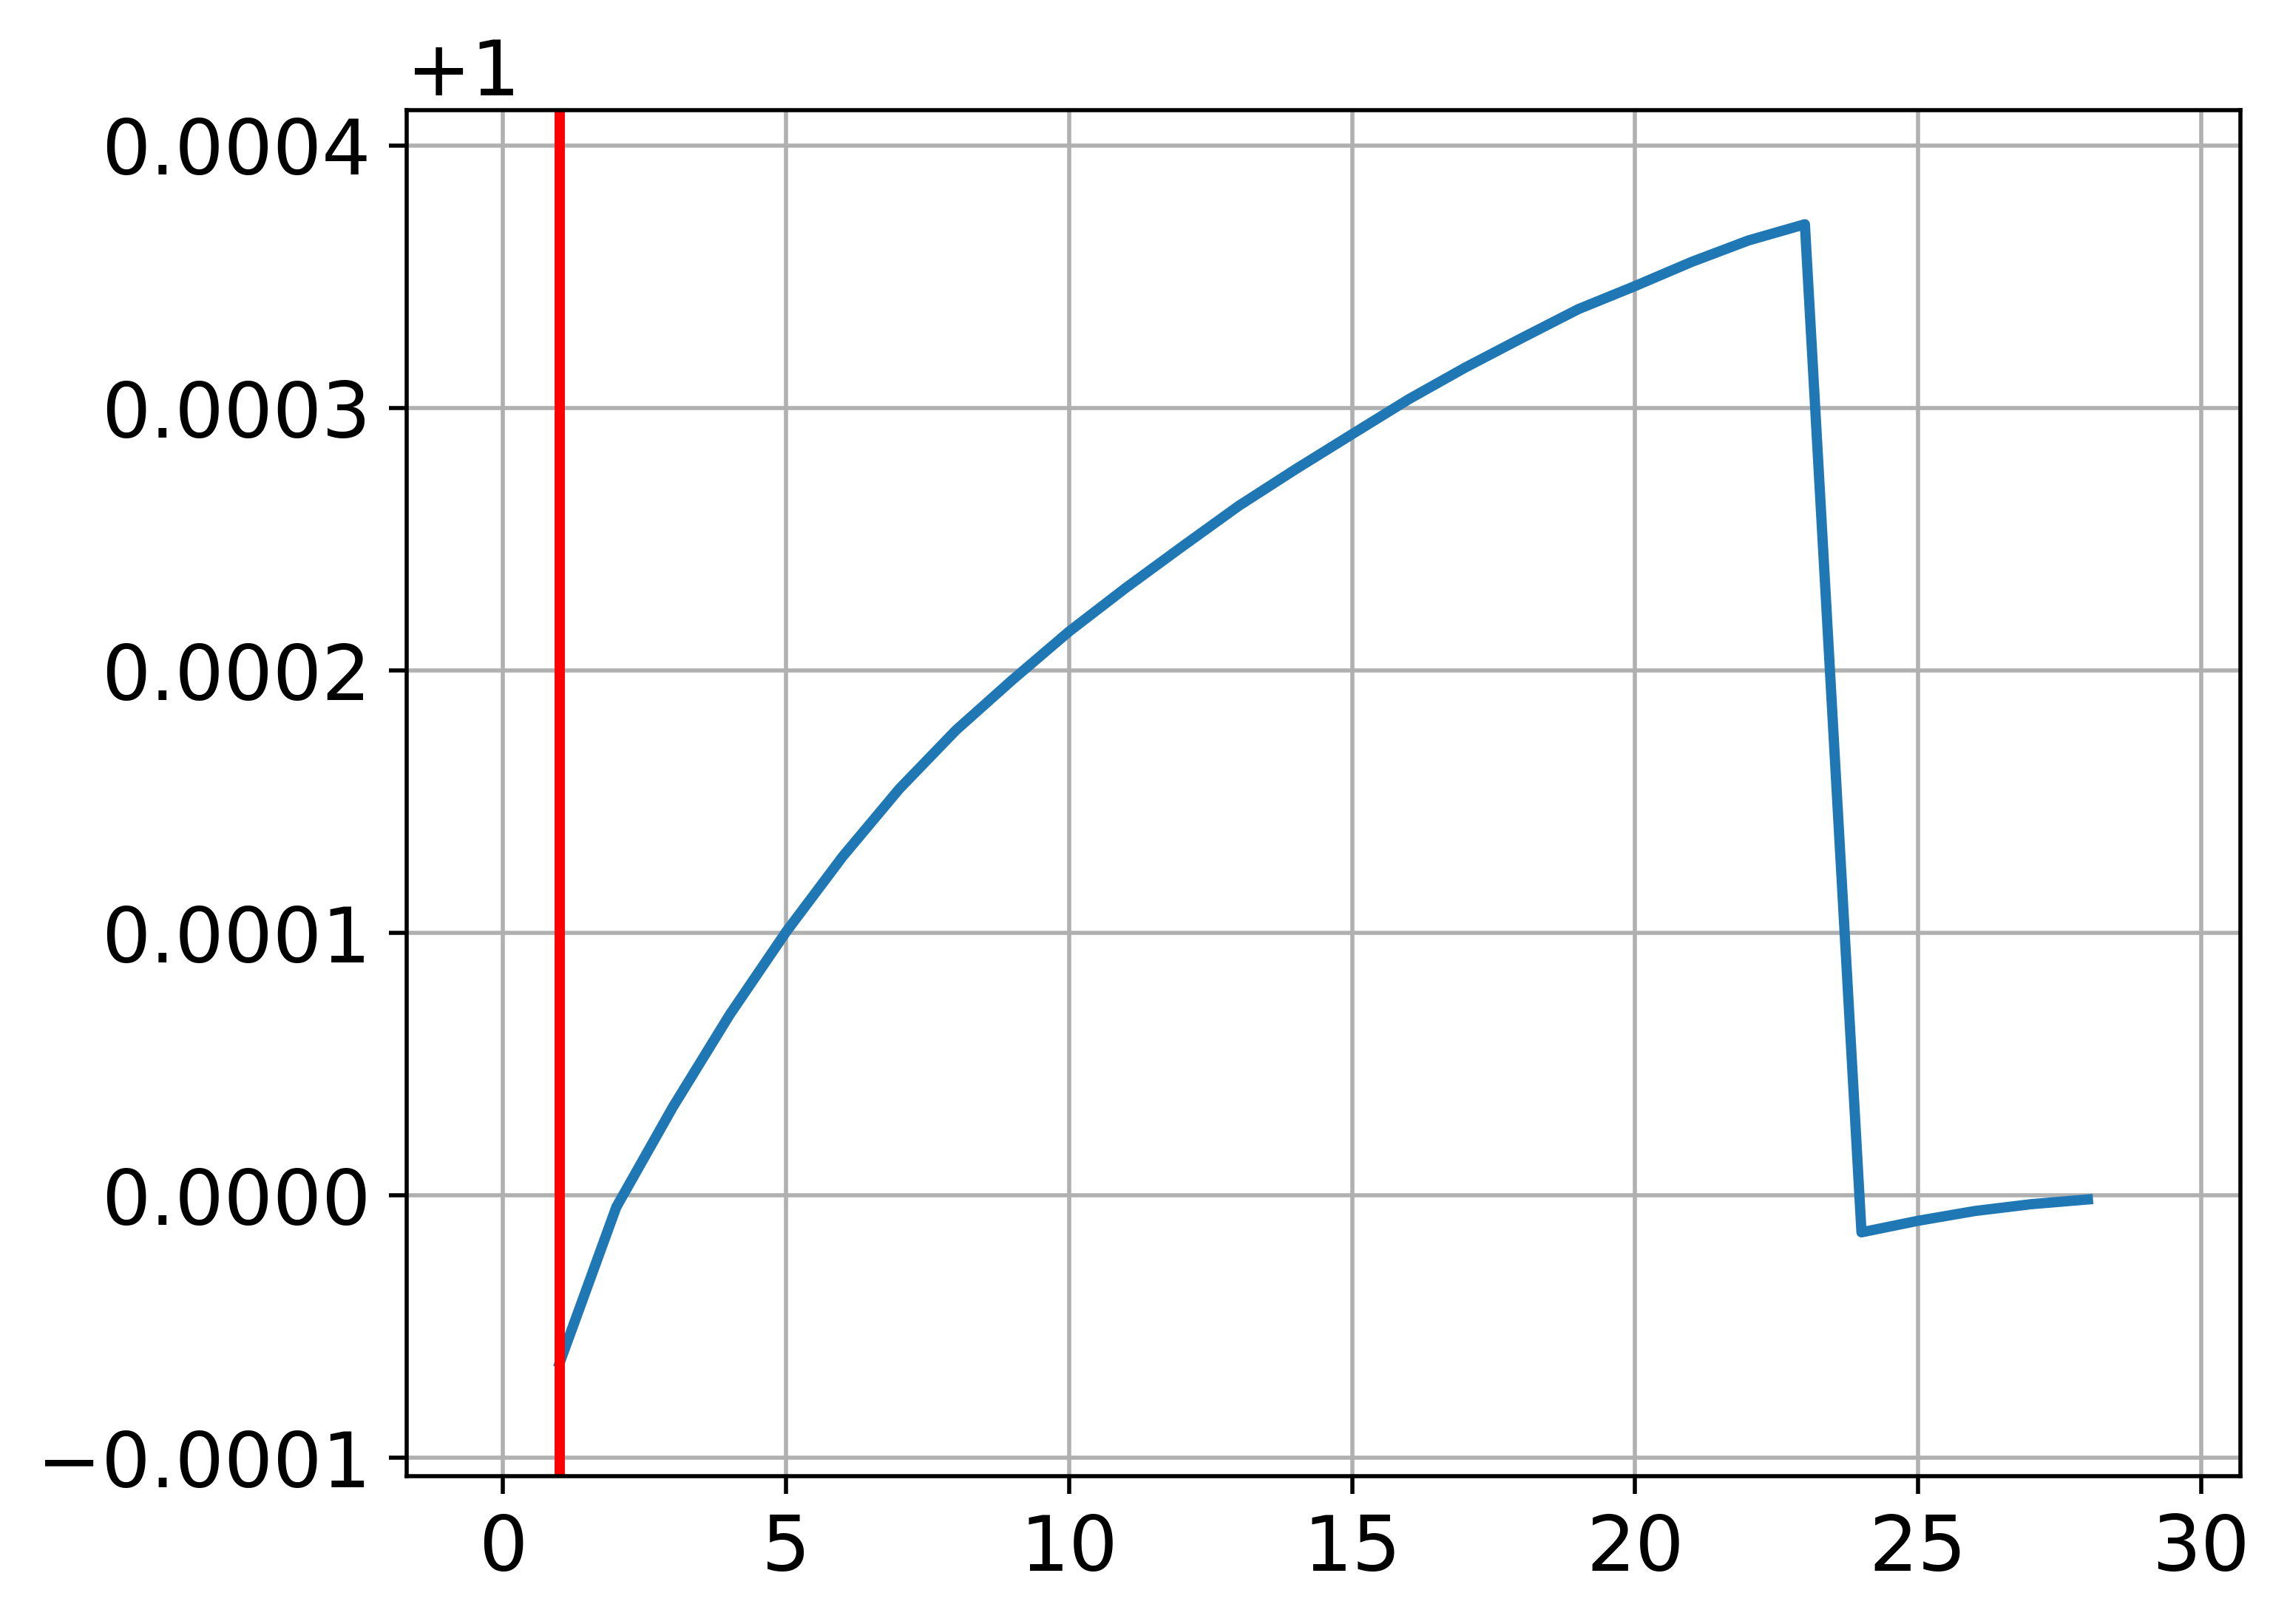

saving...
Estimating Gaussian KLD...
KLD:  0.001034379005432129
train_stats:  (array([2.395534], dtype=float32), array([[60743.523]], dtype=float32))
test_stats:  (array([-2.345956], dtype=float32), array([[64353.12]], dtype=float32))
done
KLD for yahoo_20
finding PCA...
(400, 1) (400,) (1022, 1) (1022,)
(400, 1) (400,) (989, 1) (1022,)
(1389, 1)
saving...
Estimating Gaussian KLD...
KLD:  3.6281328201293945
train_stats:  (array([0.88975006], dtype=float32), array([[0.06670094]], dtype=float32))
test_stats:  (array([0.19644085], dtype=float32), array([[0.0478031]], dtype=float32))
done
KLD for yahoo_55
finding PCA...
(400, 1) (400,) (1027, 1) (1027,)
(400, 1) (400,) (1022, 1) (1027,)
(1422, 1)
saving...
Estimating Gaussian KLD...
KLD:  1.069640874862671
train_stats:  (array([1867.2775], dtype=float32), array([[141839.12]], dtype=float32))
test_stats:  (array([1335.1018], dtype=float32), array([[231621.75]], dtype=float32))
done


In [17]:
entropies = []

# SWaT
train_X, train_y, test_X, test_y = DataFactory.load_SWaT()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[0], load=False)
entropies.append(e)

# WADI
train_X, train_y, test_X, test_y = DataFactory.load_WADI()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[1], load=False)
entropies.append(e)

# SMD_machine-1-4
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-1-4")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[2], load=False)
entropies.append(e)

# SMD_machine-2-1
train_X, train_y, test_X, test_y = DataFactory.load_SMD("machine-2-1")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[3], load=False)
entropies.append(e)

# MSL_P-15
train_X, train_y, test_X, test_y = DataFactory.load_MSL("P-15")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[4], load=False)
entropies.append(e)

# SMAP
train_X, train_y, test_X, test_y = DataFactory.load_SMAP("T-3")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[5], load=False)
entropies.append(e)

# CreditCard
train_X, train_y, test_X, test_y = DataFactory.load_CreditCard()
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[6], load=False)
entropies.append(e)

# yahoo_20
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_20")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[7], load=False)
entropies.append(e)

# yahoo_55
train_X, train_y, test_X, test_y = DataFactory.load_yahoo("real_55")
e, _, _ = plot_pcavar_return_entropy(train_X, train_y, test_X, test_y, datasets[8], load=False)
entropies.append(e)

In [18]:
df = pd.DataFrame({"Datasets": datasets_label, "KLD": entropies})
df

,Datasets,KLD
0,SWaT,1.439111e+02
1,WADI,2.943500e+07
2,SMD\n(M-1-4),1.303574e+02
3,SMD\n(M-2-1),6.233629e+00
4,MSL\n(P-15),7.432548e+02
5,SMAP\n(T-3),2.927342e+00
6,CreditCard,1.034379e-03
7,yahoo\n(A1-R20),3.628133e+00
8,yahoo\n(A1-R55),1.069641e+00


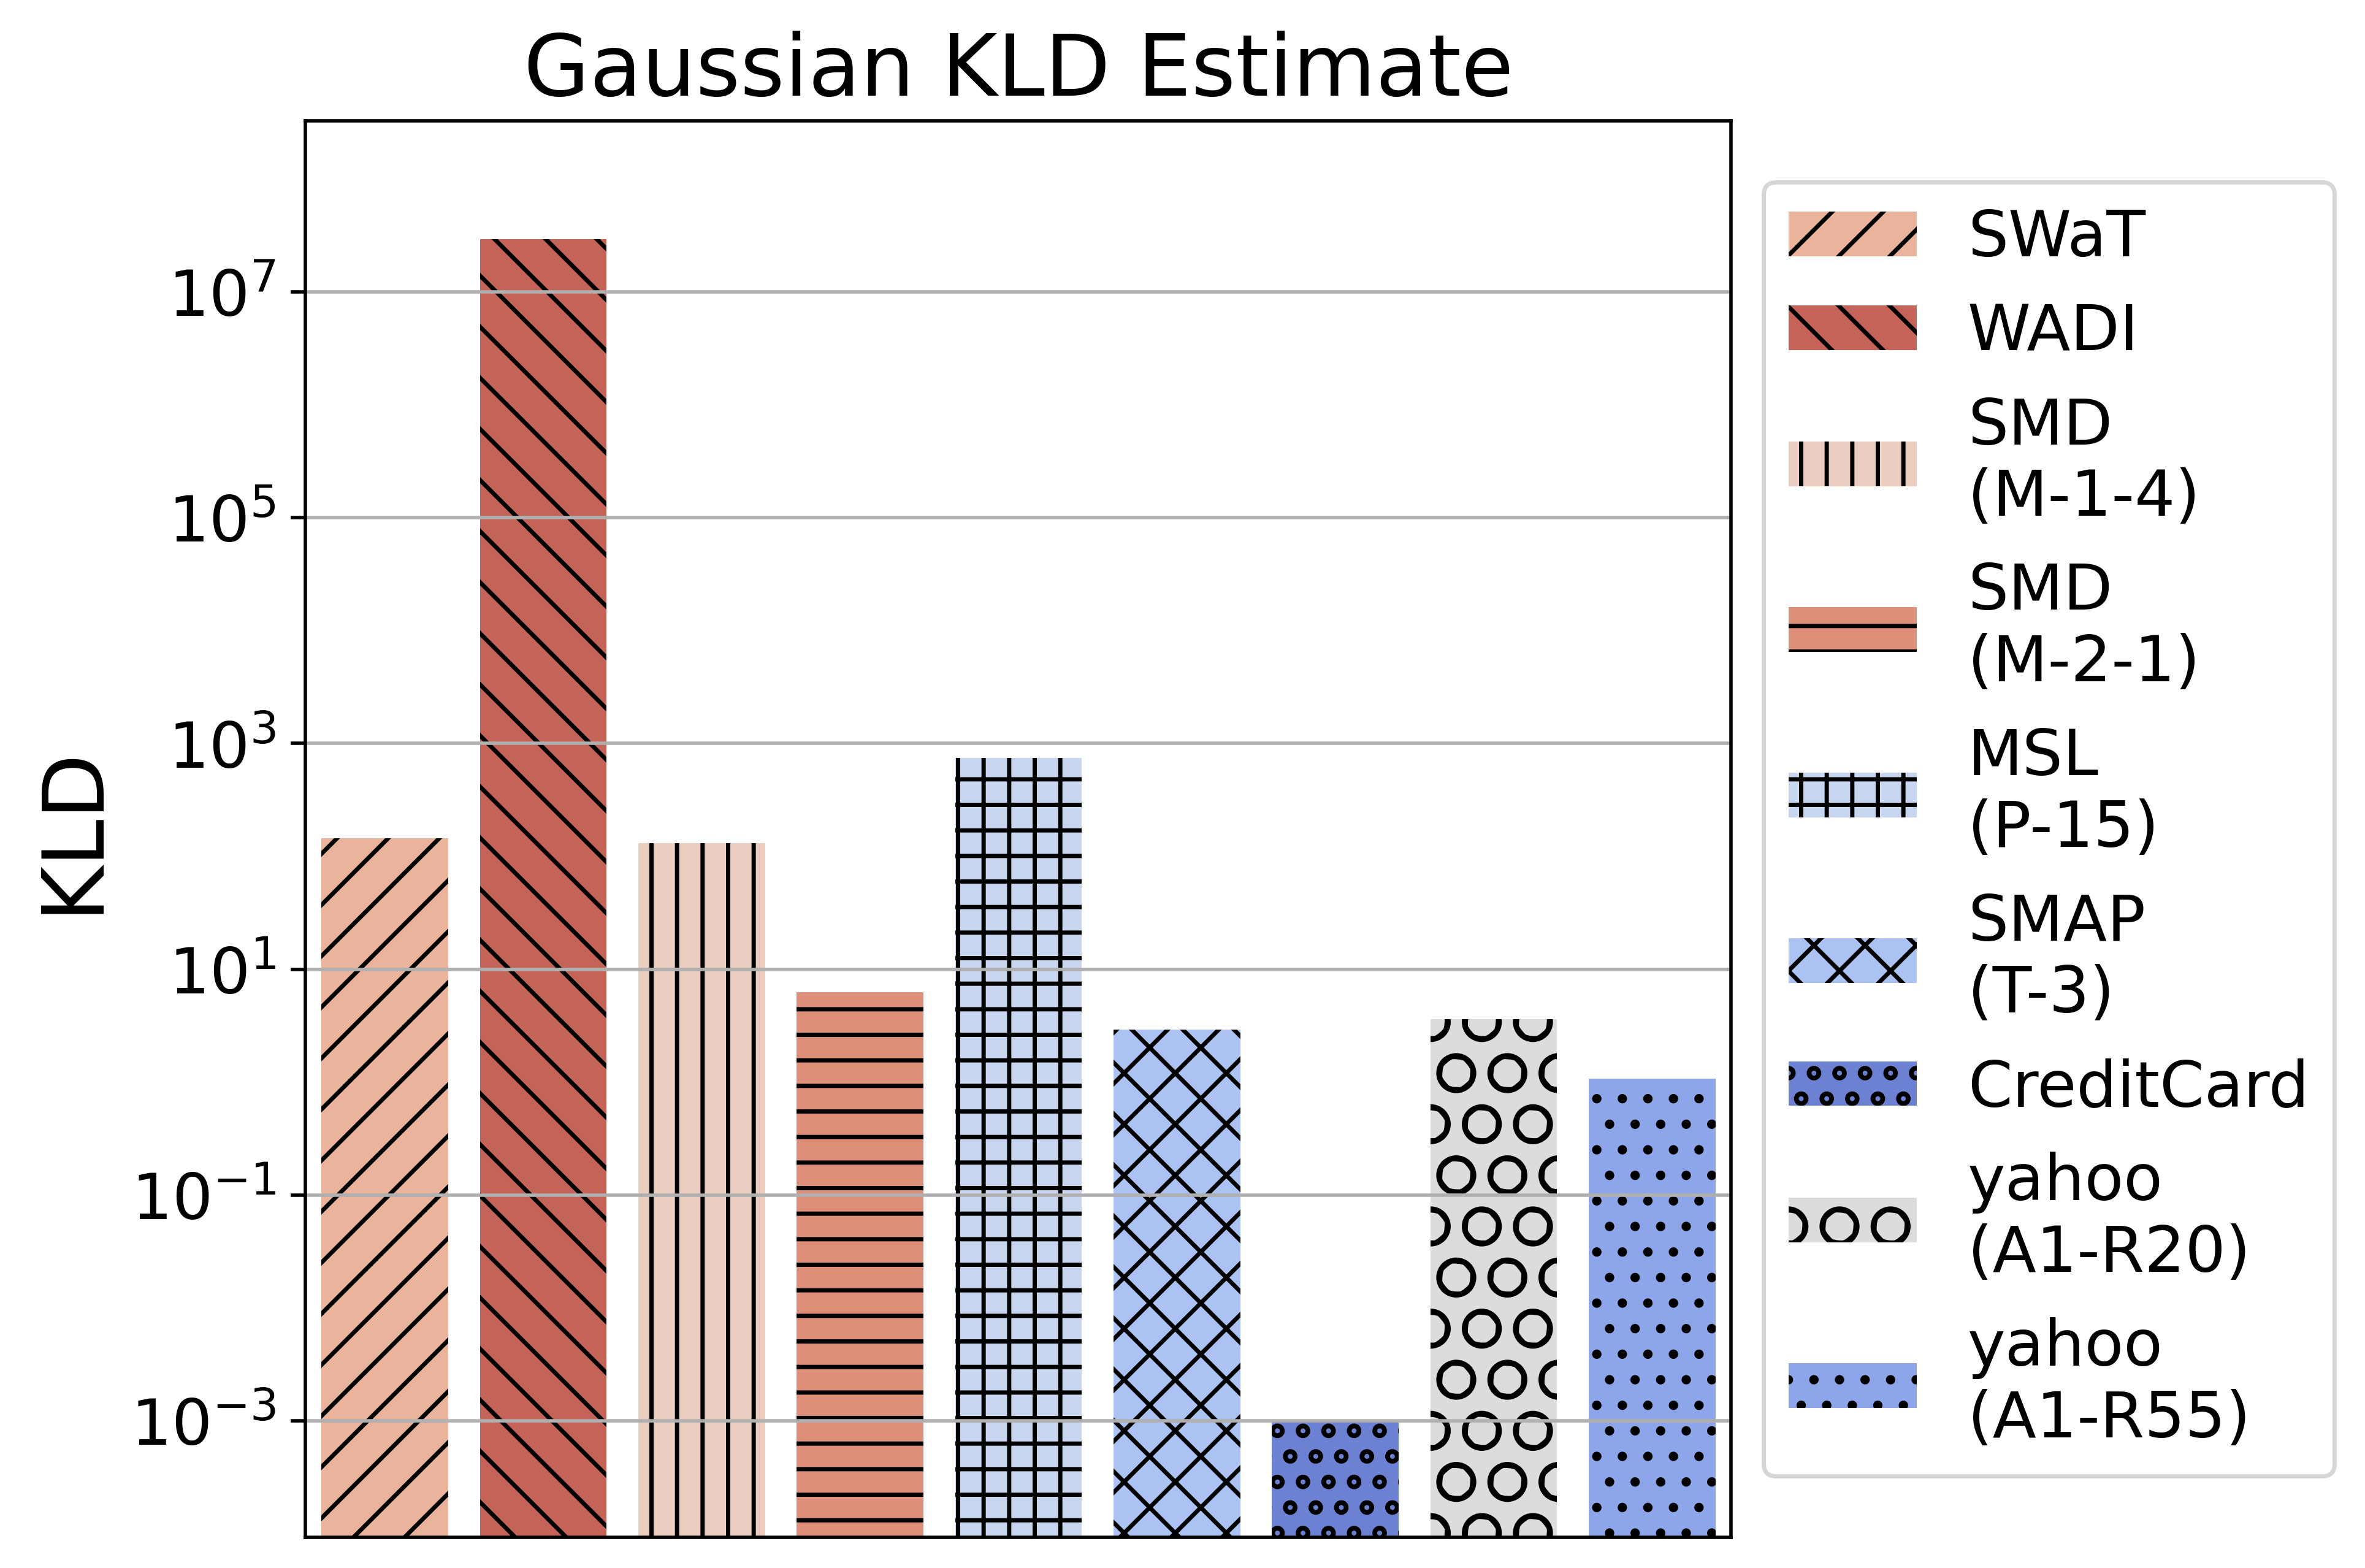

In [19]:
plt.figure(figsize=(6, 6), dpi=500)
plt.title('Gaussian KLD Estimate', fontsize=20)

pal = sns.color_palette("coolwarm", len(entropies))
rank = np.array(entropies).argsort()
bar = sns.barplot(x=datasets_label, y=entropies, palette=np.array(pal[::])[rank], alpha=.99)

hatches = ['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'O0', '..']
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_label(datasets_label[i])
    thisbar.set_hatch(hatches[i])
plt.yscale('log', base=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('KLD', fontsize=20)

bar.get_xaxis().set_visible(False)
bar.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.savefig("./figures/main_figure/kld.pdf", dpi=500,  bbox_inches = "tight")
plt.show()